# 06 - Análisis Espacial y Clustering (FINAL)

**Objetivo:** Análisis exploratorio, clustering espacial y visualizaciones finales

**Entrada:**
- CSV: `parroquias_con_petroleo.csv` (Etnia + Salud + Petróleo integrado)
- Shapefile: `LIMITE_PARROQUIAL_CONALI_CNE_2022.shp` (para mapas)

**Salidas:**
- Análisis exploratorio completo
- Modelos de clustering (K-means, DBSCAN)
- Mapas interactivos y estáticos
- Métricas de autocorrelación espacial

---

## 1. Setup e Imports

In [1]:
# Imports básicos
import pandas as pd
import numpy as np
import geopandas as gpd
from pathlib import Path
import warnings

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins

# Análisis espacial
from scipy import stats
from scipy.spatial.distance import cdist

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Autocorrelación espacial
try:
    from esda.moran import Moran
    from libpysal.weights import KNN
    PYSAL_AVAILABLE = True
except ImportError:
    print("⚠️ PySAL no está instalado. Autocorrelación espacial no disponible.")
    print("   Instalar con: pip install esda libpysal")
    PYSAL_AVAILABLE = False

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Rutas
BASE_DIR = Path('../data')
PROCESSED_DIR = BASE_DIR / 'processed'
RAW_CONALI = BASE_DIR / 'raw' / 'conali_limites'
GEO_DIR = BASE_DIR / 'geo'

# Crear directorio geo si no existe
GEO_DIR.mkdir(exist_ok=True)

print("✅ Librerías cargadas")
print(f"📁 Directorio processed: {PROCESSED_DIR}")
print(f"📁 Directorio geo: {GEO_DIR}")

✅ Librerías cargadas
📁 Directorio processed: ../data/processed
📁 Directorio geo: ../data/geo


---
## 2. Carga de Datos

In [2]:
print("📂 CARGANDO DATOS\n")
print("="*70)

# Cargar tabla final integrada
df = pd.read_csv(PROCESSED_DIR / 'parroquias_con_petroleo.csv')
print(f"✅ Datos cargados: {len(df):,} parroquias")

# Info básica
print(f"\n📋 Columnas disponibles ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  [{i:2d}] {col}")

print(f"\n📊 Dimensiones: {df.shape}")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")

print("\n" + "="*70)

📂 CARGANDO DATOS

✅ Datos cargados: 1,236 parroquias

📋 Columnas disponibles (18):
  [ 1] codigo_dpa
  [ 2] nombre_provincia
  [ 3] nombre_canton
  [ 4] nombre_parroquia
  [ 5] centroide_lon
  [ 6] centroide_lat
  [ 7] area_km2
  [ 8] poblacion_total
  [ 9] poblacion_afro
  [10] pct_poblacion_afro
  [11] num_establecimientos
  [12] densidad_establecimientos_km2
  [13] establecimientos_por_10k_hab
  [14] num_infraestructura_petrolera
  [15] num_pozos
  [16] num_sitios_contaminados
  [17] tiene_petroleo
  [18] densidad_petroleo_km2

📊 Dimensiones: (1236, 18)
   Filas: 1,236
   Columnas: 18



In [3]:
# Vista rápida de los datos
print("👀 PRIMERAS 5 FILAS:\n")
print(df.head())

print("\n" + "="*70)
print("\n📊 INFORMACIÓN DEL DATASET:\n")
print(df.info())

👀 PRIMERAS 5 FILAS:

   codigo_dpa nombre_provincia nombre_canton nombre_parroquia  centroide_lon  \
0         285            AZUAY        CUENCA            BAÑOS     -79.203461   
1         730            AZUAY        CUENCA            CUMBE     -79.020161   
2         845            AZUAY        CUENCA  CHAUCHA / ANGAS     -79.394565   
3         860            AZUAY        CUENCA     CHECA JIDCAY     -79.041224   
4         905            AZUAY        CUENCA       CHIQUINTAD     -79.056685   

   centroide_lat  area_km2  poblacion_total  poblacion_afro  \
0      -2.983540    251.44          21797.0            26.0   
1      -3.102251     75.13           6455.0             0.0   
2      -2.930624    380.00           1721.0             2.0   
3      -2.711074    110.86           3204.0            24.0   
4      -2.769097     93.44           5738.0            24.0   

   pct_poblacion_afro  num_establecimientos  densidad_establecimientos_km2  \
0                0.12                    

---
## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Estadísticas Descriptivas

In [4]:
print("📊 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES CLAVE\n")
print("="*70)

# Variables de interés
vars_interes = [
    'poblacion_total',
    'poblacion_afro',
    'pct_poblacion_afro',
    'num_establecimientos',
    'establecimientos_por_10k_hab',
    'num_infraestructura_petrolera',
    'num_pozos',
    'num_sitios_contaminados',
    'densidad_petroleo_km2',
    'area_km2'
]

# Filtrar solo las que existen en el df
vars_disponibles = [v for v in vars_interes if v in df.columns]

print(f"Variables analizadas: {len(vars_disponibles)}")
print(df[vars_disponibles].describe().T)

print("\n" + "="*70)

📊 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES CLAVE

Variables analizadas: 10
                                count          mean           std     min  \
poblacion_total                 847.0  10907.698937  28677.619994  104.00   
poblacion_afro                  847.0    193.719008    939.581699    0.00   
pct_poblacion_afro              847.0      2.389870      9.185656    0.00   
num_establecimientos           1236.0      3.430421      7.656863    0.00   
establecimientos_por_10k_hab    847.0      7.579374      8.454732    0.00   
num_infraestructura_petrolera  1236.0      9.500000     84.223536    0.00   
num_pozos                      1236.0      3.815534     43.635033    0.00   
num_sitios_contaminados        1236.0      5.684466     58.317801    0.00   
densidad_petroleo_km2          1236.0      0.075093      0.862476    0.00   
area_km2                       1236.0    208.102888    508.167433    0.39   

                                   25%      50%        75%          max  
poblac

### 3.2 Análisis de Valores Perdidos

In [5]:
print("🔍 ANÁLISIS DE VALORES PERDIDOS\n")
print("="*70)

# Calcular missing values
missing = df[vars_disponibles].isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Variable': missing.index,
    'Missing': missing.values,
    'Porcentaje': missing_pct.values
}).sort_values('Missing', ascending=False)

print(missing_df.to_string(index=False))

# Identificar variables críticas con muchos NaN
vars_criticas = missing_df[missing_df['Porcentaje'] > 30]
if len(vars_criticas) > 0:
    print(f"\n⚠️ Variables con >30% de datos faltantes:")
    print(vars_criticas.to_string(index=False))
else:
    print(f"\n✅ No hay variables con >30% de datos faltantes")

print("\n" + "="*70)

🔍 ANÁLISIS DE VALORES PERDIDOS

                     Variable  Missing  Porcentaje
              poblacion_total      389       31.47
               poblacion_afro      389       31.47
           pct_poblacion_afro      389       31.47
 establecimientos_por_10k_hab      389       31.47
         num_establecimientos        0        0.00
num_infraestructura_petrolera        0        0.00
                    num_pozos        0        0.00
      num_sitios_contaminados        0        0.00
        densidad_petroleo_km2        0        0.00
                     area_km2        0        0.00

⚠️ Variables con >30% de datos faltantes:
                    Variable  Missing  Porcentaje
             poblacion_total      389       31.47
              poblacion_afro      389       31.47
          pct_poblacion_afro      389       31.47
establecimientos_por_10k_hab      389       31.47



### 3.3 Distribución de Variables Clave

📊 DISTRIBUCIONES DE VARIABLES CLAVE



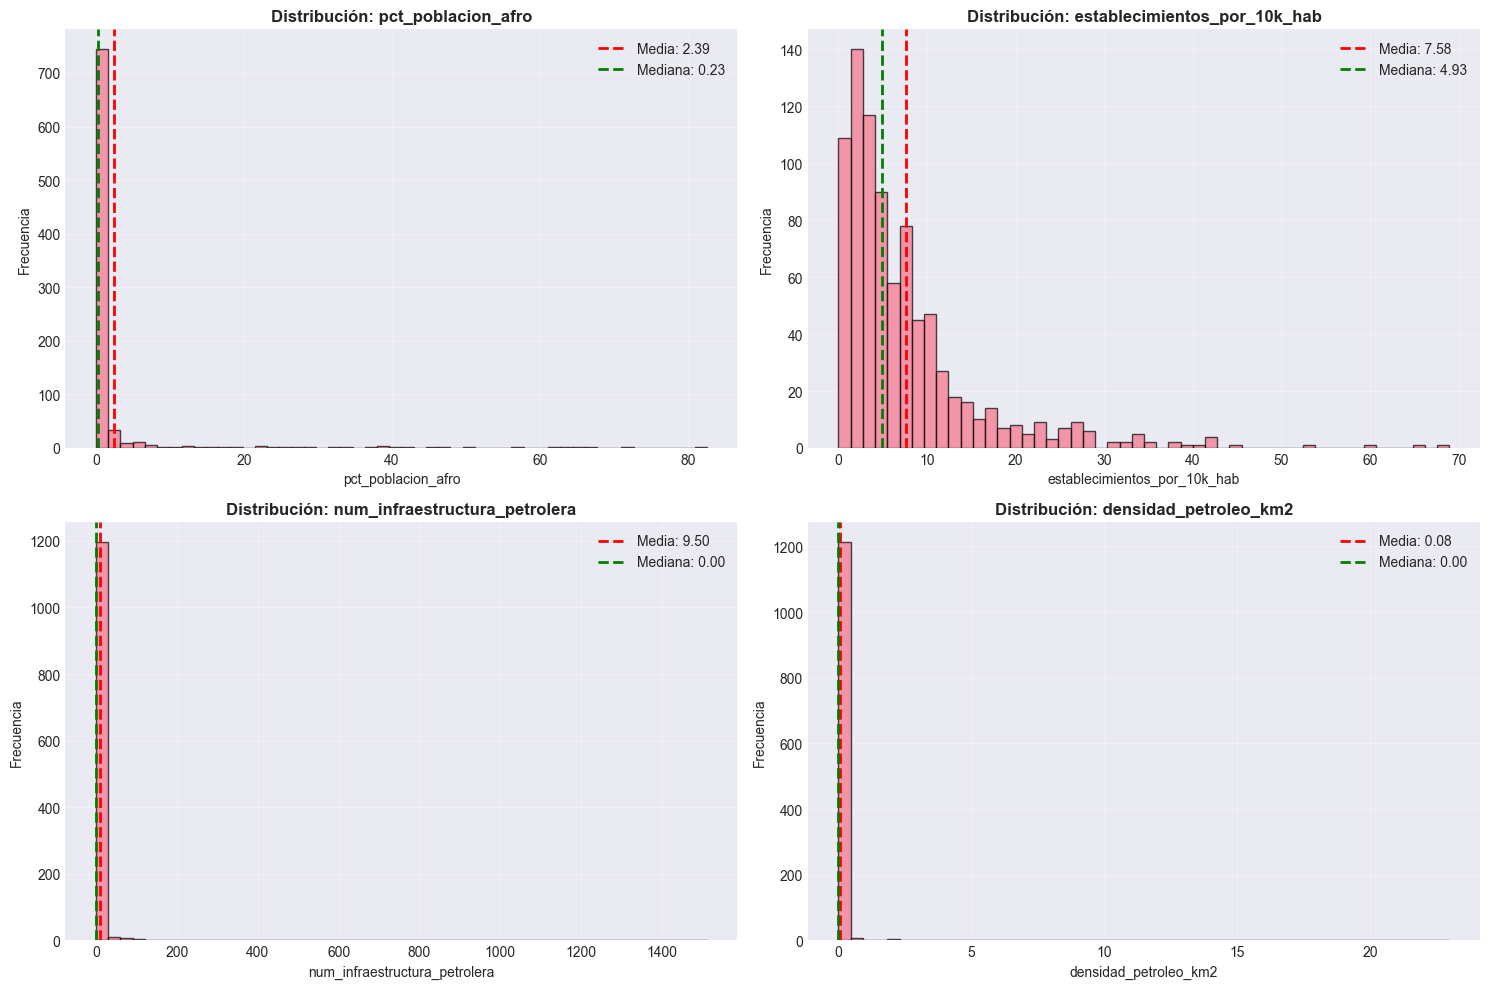

✅ Distribuciones generadas


In [6]:
print("📊 DISTRIBUCIONES DE VARIABLES CLAVE\n")
print("="*70)

# Variables para visualizar
vars_plot = ['pct_poblacion_afro', 'establecimientos_por_10k_hab', 
             'num_infraestructura_petrolera', 'densidad_petroleo_km2']

# Filtrar las que existen
vars_plot = [v for v in vars_plot if v in df.columns]

# Crear subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, var in enumerate(vars_plot):
    # Filtrar valores no nulos
    data = df[var].dropna()
    
    # Histograma
    axes[i].hist(data, bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribución: {var}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True, alpha=0.3)
    
    # Estadísticas en el gráfico
    mean_val = data.mean()
    median_val = data.median()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

print("✅ Distribuciones generadas")

### 3.4 Boxplots para Detectar Outliers

📦 BOXPLOTS - DETECCIÓN DE OUTLIERS



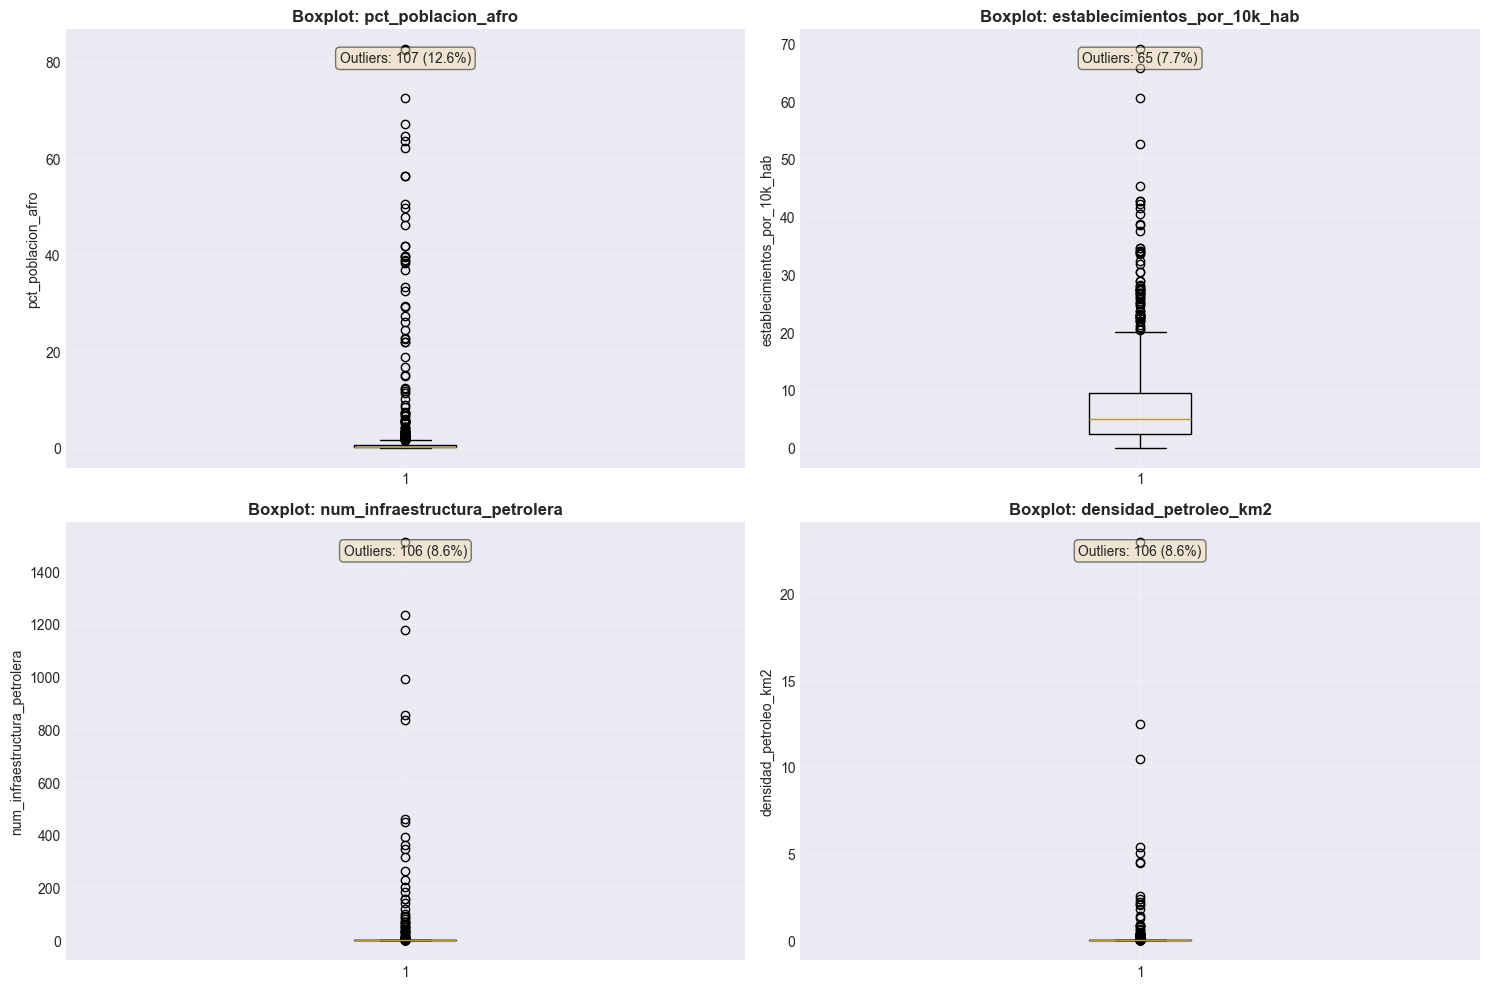

✅ Boxplots generados


In [7]:
print("📦 BOXPLOTS - DETECCIÓN DE OUTLIERS\n")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, var in enumerate(vars_plot):
    data = df[var].dropna()
    
    axes[i].boxplot(data, vert=True)
    axes[i].set_title(f'Boxplot: {var}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(var)
    axes[i].grid(True, alpha=0.3)
    
    # Calcular outliers
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]
    
    axes[i].text(0.5, 0.95, f'Outliers: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)',
                 transform=axes[i].transAxes, ha='center', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✅ Boxplots generados")

---
## 4. Análisis de Correlaciones

### 4.1 Matriz de Correlación

🔗 MATRIZ DE CORRELACIÓN



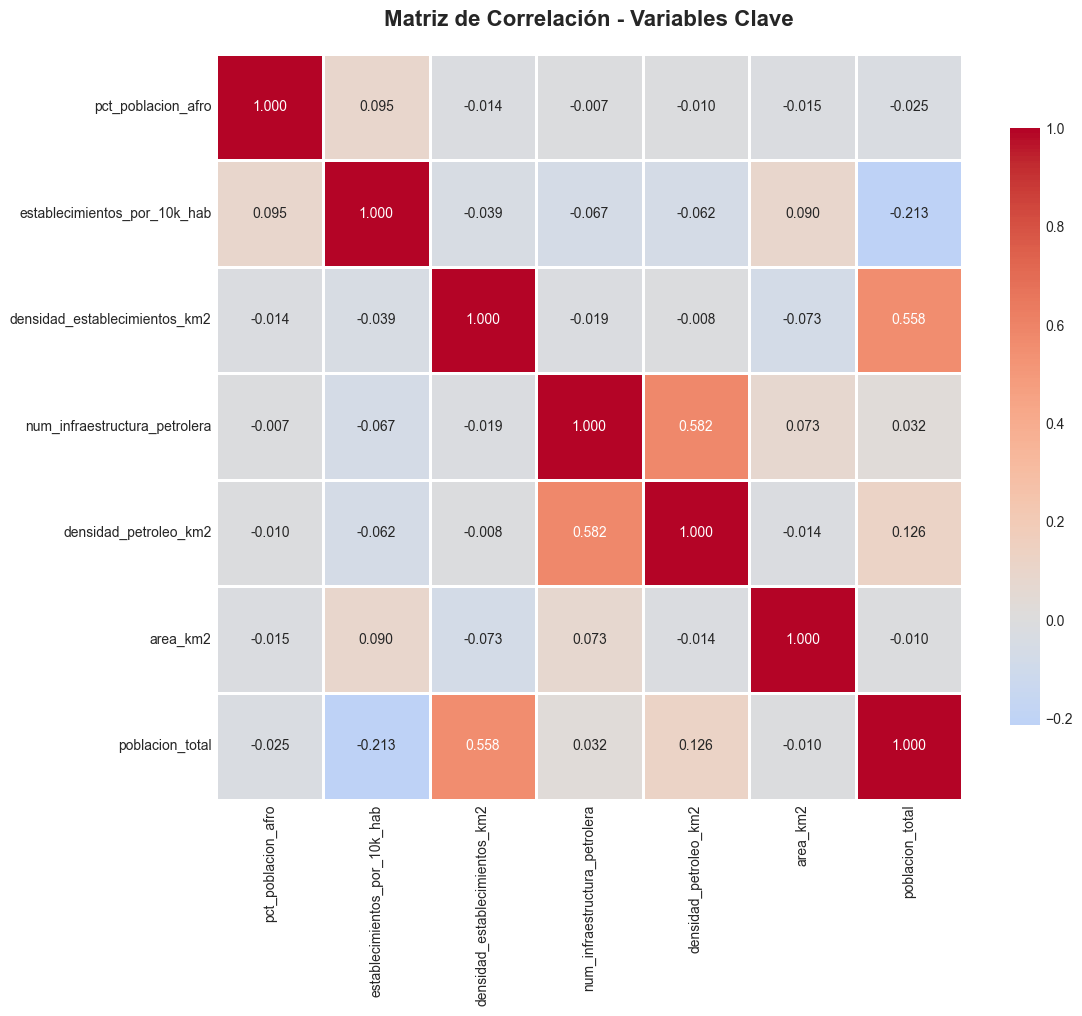


✅ Matriz de correlación generada

🔝 CORRELACIONES MÁS FUERTES (|r| > 0.3):

  num_infraestructura_petrolera <-> densidad_petroleo_km2: 0.582
  densidad_establecimientos_km2 <-> poblacion_total: 0.558



In [8]:
print("🔗 MATRIZ DE CORRELACIÓN\n")
print("="*70)

# Variables para correlación
vars_corr = [
    'pct_poblacion_afro',
    'establecimientos_por_10k_hab',
    'densidad_establecimientos_km2',
    'num_infraestructura_petrolera',
    'densidad_petroleo_km2',
    'area_km2',
    'poblacion_total'
]

# Filtrar las que existen
vars_corr = [v for v in vars_corr if v in df.columns]

# Calcular matriz de correlación
corr_matrix = df[vars_corr].corr()

# Visualizar con heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables Clave', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n✅ Matriz de correlación generada")

# Mostrar correlaciones más fuertes
print("\n🔝 CORRELACIONES MÁS FUERTES (|r| > 0.3):\n")
correlaciones_fuertes = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        var1 = corr_matrix.columns[i]
        var2 = corr_matrix.columns[j]
        valor = corr_matrix.iloc[i, j]
        if abs(valor) > 0.3:
            correlaciones_fuertes.append((var1, var2, valor))

correlaciones_fuertes.sort(key=lambda x: abs(x[2]), reverse=True)

for var1, var2, valor in correlaciones_fuertes:
    print(f"  {var1} <-> {var2}: {valor:.3f}")

print("\n" + "="*70)

### 4.2 Scatter Plots: Petróleo vs Salud vs Etnia

📈 SCATTER PLOTS - RELACIONES CLAVE

Parroquias con datos completos: 847 de 1,236


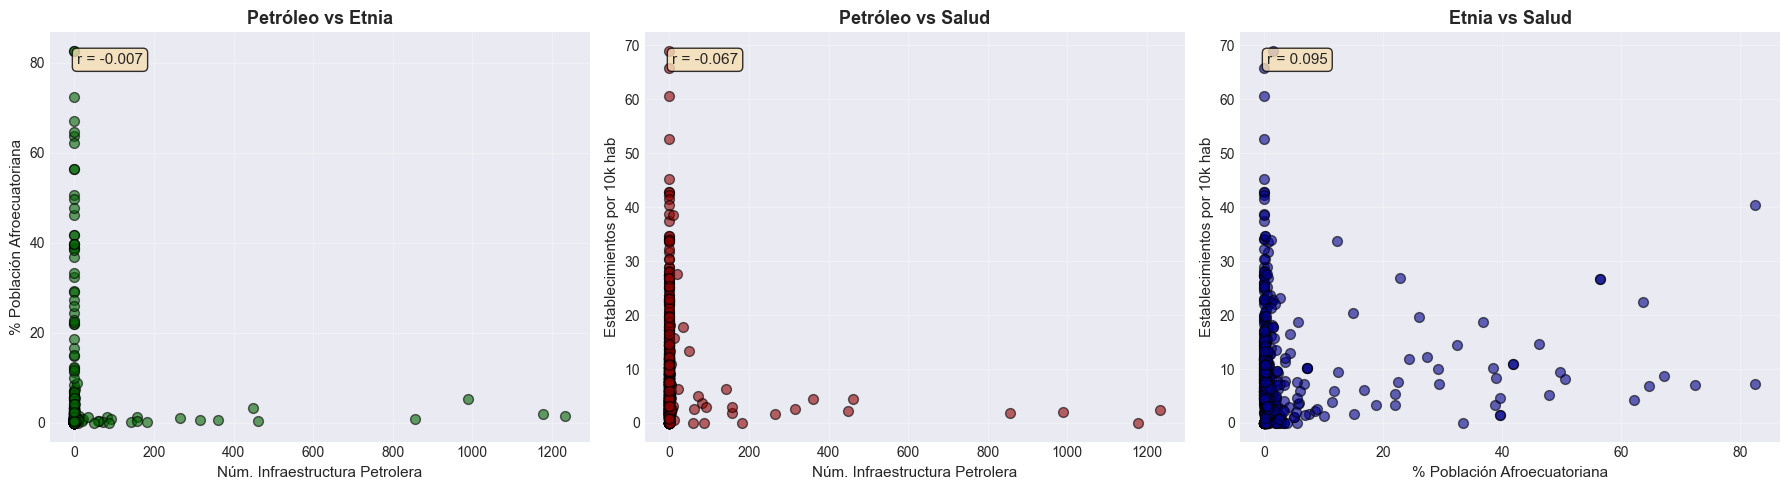


✅ Scatter plots generados



In [9]:
print("📈 SCATTER PLOTS - RELACIONES CLAVE\n")
print("="*70)

# Filtrar parroquias con datos completos
df_completo = df.dropna(subset=['pct_poblacion_afro', 'establecimientos_por_10k_hab', 
                                'num_infraestructura_petrolera'])

print(f"Parroquias con datos completos: {len(df_completo):,} de {len(df):,}")

# Crear figura con 3 scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Petróleo vs Población Afro
axes[0].scatter(df_completo['num_infraestructura_petrolera'], 
                df_completo['pct_poblacion_afro'],
                alpha=0.6, s=50, c='darkgreen', edgecolors='black')
axes[0].set_xlabel('Núm. Infraestructura Petrolera', fontsize=11)
axes[0].set_ylabel('% Población Afroecuatoriana', fontsize=11)
axes[0].set_title('Petróleo vs Etnia', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Calcular correlación
corr1 = df_completo['num_infraestructura_petrolera'].corr(df_completo['pct_poblacion_afro'])
axes[0].text(0.05, 0.95, f'r = {corr1:.3f}', transform=axes[0].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

# 2. Petróleo vs Salud
axes[1].scatter(df_completo['num_infraestructura_petrolera'], 
                df_completo['establecimientos_por_10k_hab'],
                alpha=0.6, s=50, c='darkred', edgecolors='black')
axes[1].set_xlabel('Núm. Infraestructura Petrolera', fontsize=11)
axes[1].set_ylabel('Establecimientos por 10k hab', fontsize=11)
axes[1].set_title('Petróleo vs Salud', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

corr2 = df_completo['num_infraestructura_petrolera'].corr(df_completo['establecimientos_por_10k_hab'])
axes[1].text(0.05, 0.95, f'r = {corr2:.3f}', transform=axes[1].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

# 3. Etnia vs Salud
axes[2].scatter(df_completo['pct_poblacion_afro'], 
                df_completo['establecimientos_por_10k_hab'],
                alpha=0.6, s=50, c='darkblue', edgecolors='black')
axes[2].set_xlabel('% Población Afroecuatoriana', fontsize=11)
axes[2].set_ylabel('Establecimientos por 10k hab', fontsize=11)
axes[2].set_title('Etnia vs Salud', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

corr3 = df_completo['pct_poblacion_afro'].corr(df_completo['establecimientos_por_10k_hab'])
axes[2].text(0.05, 0.95, f'r = {corr3:.3f}', transform=axes[2].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✅ Scatter plots generados")
print("\n" + "="*70)

---
## 5. Clustering Espacial

### 5.1 Preparación de Datos para Clustering

In [10]:
print("🔧 PREPARACIÓN DE DATOS PARA CLUSTERING\n")
print("="*70)

# Features para clustering
features_clustering = [
    'pct_poblacion_afro',
    'establecimientos_por_10k_hab',
    'densidad_petroleo_km2',
    'centroide_lat',
    'centroide_lon'
]

# Verificar que existen
features_disponibles = [f for f in features_clustering if f in df.columns]
print(f"Features disponibles: {features_disponibles}")

# Crear dataset para clustering (sin NaN)
df_cluster = df[features_disponibles].dropna().copy()
print(f"\nParroquias para clustering: {len(df_cluster):,} (de {len(df):,} totales)")
print(f"Datos eliminados: {len(df) - len(df_cluster):,} ({(len(df) - len(df_cluster))/len(df)*100:.1f}%)")

# Normalizar datos (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

print(f"\n✅ Datos normalizados (media=0, std=1)")
print(f"   Shape: {X_scaled.shape}")

# Guardar índices originales para mapear después
indices_originales = df_cluster.index

print("\n" + "="*70)

🔧 PREPARACIÓN DE DATOS PARA CLUSTERING

Features disponibles: ['pct_poblacion_afro', 'establecimientos_por_10k_hab', 'densidad_petroleo_km2', 'centroide_lat', 'centroide_lon']

Parroquias para clustering: 847 (de 1,236 totales)
Datos eliminados: 389 (31.5%)

✅ Datos normalizados (media=0, std=1)
   Shape: (847, 5)



### 5.2 K-Means Clustering

In [11]:
print("🎯 K-MEANS CLUSTERING\n")
print("="*70)

# Probar diferentes valores de K
K_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("Evaluando K = 2 a 10...\n")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))
    
    print(f"K={k}: Silhouette={silhouette_scores[-1]:.3f}, Davies-Bouldin={davies_bouldin_scores[-1]:.3f}")

print("\n" + "="*70)

🎯 K-MEANS CLUSTERING

Evaluando K = 2 a 10...

K=2: Silhouette=0.613, Davies-Bouldin=0.659
K=3: Silhouette=0.622, Davies-Bouldin=0.591
K=4: Silhouette=0.328, Davies-Bouldin=0.922
K=5: Silhouette=0.337, Davies-Bouldin=0.793
K=6: Silhouette=0.343, Davies-Bouldin=0.759
K=7: Silhouette=0.336, Davies-Bouldin=0.829
K=8: Silhouette=0.338, Davies-Bouldin=0.763
K=9: Silhouette=0.291, Davies-Bouldin=0.809
K=10: Silhouette=0.300, Davies-Bouldin=0.807



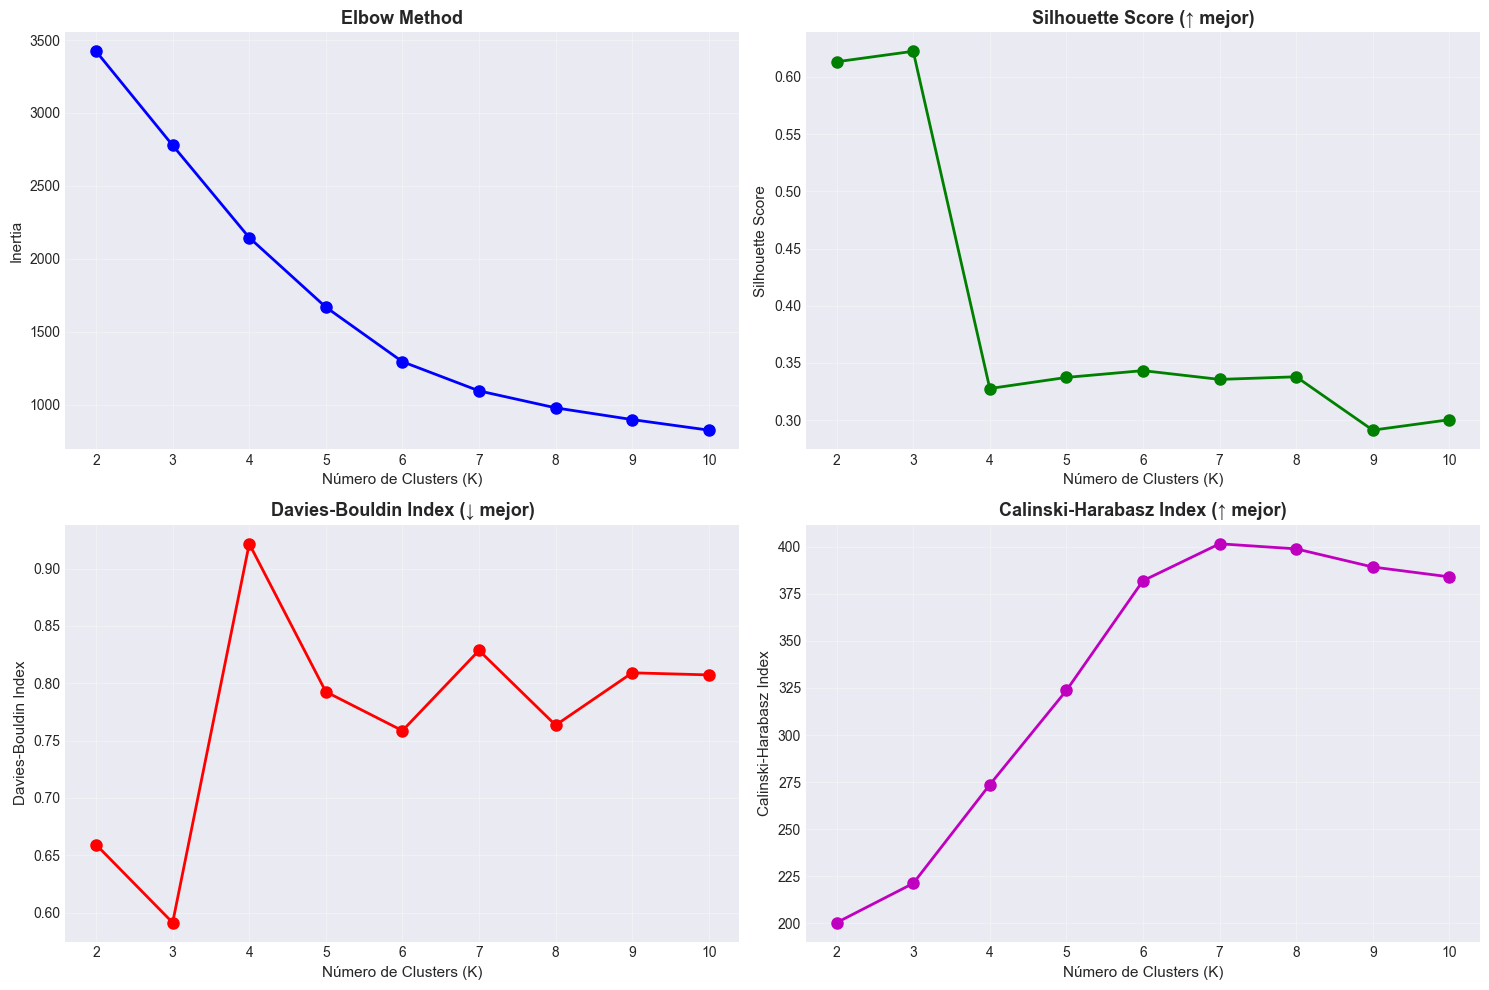

✅ Métricas de evaluación generadas


In [12]:
# Visualizar métricas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Elbow Method (Inertia)
axes[0, 0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Número de Clusters (K)', fontsize=11)
axes[0, 0].set_ylabel('Inertia', fontsize=11)
axes[0, 0].set_title('Elbow Method', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Silhouette Score (mayor es mejor)
axes[0, 1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Número de Clusters (K)', fontsize=11)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 1].set_title('Silhouette Score (↑ mejor)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Davies-Bouldin Index (menor es mejor)
axes[1, 0].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Número de Clusters (K)', fontsize=11)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[1, 0].set_title('Davies-Bouldin Index (↓ mejor)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Calinski-Harabasz Index (mayor es mejor)
axes[1, 1].plot(K_range, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Número de Clusters (K)', fontsize=11)
axes[1, 1].set_ylabel('Calinski-Harabasz Index', fontsize=11)
axes[1, 1].set_title('Calinski-Harabasz Index (↑ mejor)', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Métricas de evaluación generadas")

In [13]:
# Seleccionar K óptimo (puedes cambiar según análisis visual)
K_OPTIMO = 4  # Ajusta según tus métricas

print(f"🎯 APLICANDO K-MEANS CON K={K_OPTIMO}\n")
print("="*70)

# Entrenar modelo final
kmeans_final = KMeans(n_clusters=K_OPTIMO, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_scaled)

# Agregar labels al dataframe original
df.loc[indices_originales, 'cluster_kmeans'] = labels_kmeans

# Métricas finales
print(f"✅ Clustering completado")
print(f"\n📊 Métricas finales (K={K_OPTIMO}):")
print(f"   Silhouette Score: {silhouette_score(X_scaled, labels_kmeans):.3f}")
print(f"   Davies-Bouldin Index: {davies_bouldin_score(X_scaled, labels_kmeans):.3f}")
print(f"   Calinski-Harabasz Index: {calinski_harabasz_score(X_scaled, labels_kmeans):.1f}")

# Distribución de clusters
print(f"\n📊 Distribución de parroquias por cluster:")
cluster_counts = pd.Series(labels_kmeans).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"   Cluster {cluster}: {count:,} parroquias ({count/len(labels_kmeans)*100:.1f}%)")

print("\n" + "="*70)

🎯 APLICANDO K-MEANS CON K=4

✅ Clustering completado

📊 Métricas finales (K=4):
   Silhouette Score: 0.328
   Davies-Bouldin Index: 0.922
   Calinski-Harabasz Index: 273.6

📊 Distribución de parroquias por cluster:
   Cluster 0: 335 parroquias (39.6%)
   Cluster 1: 478 parroquias (56.4%)
   Cluster 2: 31 parroquias (3.7%)
   Cluster 3: 3 parroquias (0.4%)



### 5.3 Caracterización de Clusters

📊 CARACTERIZACIÓN DE CLUSTERS (K-MEANS)


Promedios por cluster:

                pct_poblacion_afro  establecimientos_por_10k_hab  \
cluster_kmeans                                                     
0                             0.34                         10.54   
1                             1.05                          5.26   
2                            45.32                         11.85   
3                             1.07                          1.81   

                densidad_petroleo_km2  centroide_lat  centroide_lon  
cluster_kmeans                                                       
0                                0.01          -3.28         -79.52  
1                                0.03          -0.82         -78.75  
2                                0.00           0.92         -78.69  
3                                6.77          -1.61         -79.55  


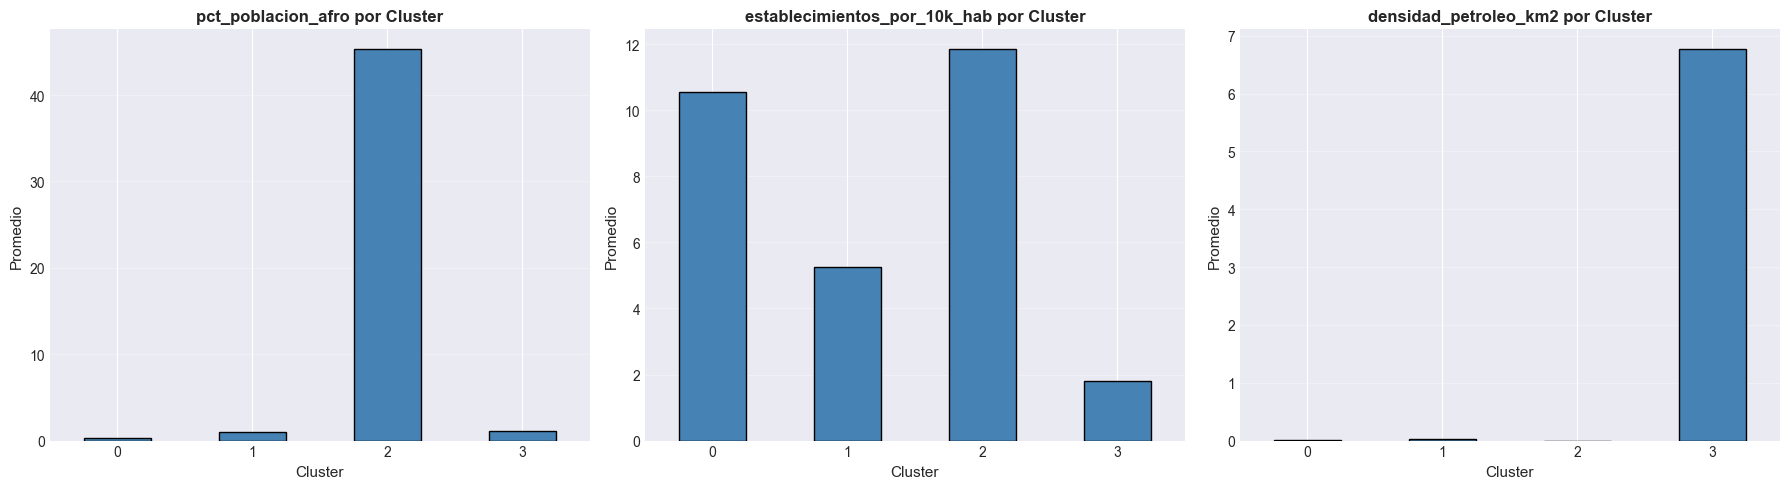


✅ Caracterización completada



In [15]:
print("📊 CARACTERIZACIÓN DE CLUSTERS (K-MEANS)\n")
print("="*70)

# Calcular promedios por cluster
df_con_clusters = df.loc[indices_originales].copy()
df_con_clusters['cluster_kmeans'] = labels_kmeans

caracterizacion = df_con_clusters.groupby('cluster_kmeans')[features_disponibles].mean()

print("\nPromedios por cluster:\n")
print(caracterizacion.round(2))

# Visualizar características por cluster
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

vars_viz = ['pct_poblacion_afro', 'establecimientos_por_10k_hab', 'densidad_petroleo_km2']
vars_viz = [v for v in vars_viz if v in caracterizacion.columns]

for i, var in enumerate(vars_viz):
    caracterizacion[var].plot(kind='bar', ax=axes[i], color='steelblue', edgecolor='black')
    axes[i].set_title(f'{var} por Cluster', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Cluster', fontsize=11)
    axes[i].set_ylabel('Promedio', fontsize=11)
    axes[i].grid(True, alpha=0.3, axis='y')
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\n✅ Caracterización completada")
print("\n" + "="*70)

### 5.4 DBSCAN Clustering (Alternativo)

In [16]:
print("🎯 DBSCAN CLUSTERING\n")
print("="*70)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

# Agregar labels al dataframe
df.loc[indices_originales, 'cluster_dbscan'] = labels_dbscan

# Análisis de resultados
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"✅ DBSCAN completado")
print(f"\n📊 Resultados:")
print(f"   Clusters encontrados: {n_clusters_dbscan}")
print(f"   Puntos de ruido (noise): {n_noise} ({n_noise/len(labels_dbscan)*100:.1f}%)")

# Distribución de clusters
if n_clusters_dbscan > 0:
    print(f"\n📊 Distribución de parroquias por cluster:")
    cluster_counts = pd.Series(labels_dbscan).value_counts().sort_index()
    for cluster, count in cluster_counts.items():
        if cluster == -1:
            print(f"   Noise (-1): {count:,} parroquias")
        else:
            print(f"   Cluster {cluster}: {count:,} parroquias ({count/len(labels_dbscan)*100:.1f}%)")
    
    # Calcular silhouette solo para puntos no-noise
    if n_noise < len(labels_dbscan):
        mask_no_noise = labels_dbscan != -1
        if len(set(labels_dbscan[mask_no_noise])) > 1:
            sil_score = silhouette_score(X_scaled[mask_no_noise], labels_dbscan[mask_no_noise])
            print(f"\n   Silhouette Score (sin noise): {sil_score:.3f}")
else:
    print("\n⚠️ DBSCAN no encontró clusters definidos. Ajusta eps o min_samples.")

print("\n" + "="*70)

🎯 DBSCAN CLUSTERING

✅ DBSCAN completado

📊 Resultados:
   Clusters encontrados: 3
   Puntos de ruido (noise): 113 (13.3%)

📊 Distribución de parroquias por cluster:
   Noise (-1): 113 parroquias
   Cluster 0: 719 parroquias (84.9%)
   Cluster 1: 5 parroquias (0.6%)
   Cluster 2: 10 parroquias (1.2%)

   Silhouette Score (sin noise): 0.248



---
## 6. Autocorrelación Espacial (Moran's I)

In [17]:
if PYSAL_AVAILABLE:
    print("🗺️ AUTOCORRELACIÓN ESPACIAL (MORAN'S I)\n")
    print("="*70)
    
    # Preparar datos espaciales
    df_spatial = df.dropna(subset=['centroide_lat', 'centroide_lon', 'densidad_petroleo_km2']).copy()
    
    if len(df_spatial) > 10:
        # Crear matriz de pesos espaciales (K-nearest neighbors)
        coords = df_spatial[['centroide_lon', 'centroide_lat']].values
        w = KNN.from_array(coords, k=8)
        
        # Variables para analizar
        vars_moran = ['densidad_petroleo_km2', 'pct_poblacion_afro', 'establecimientos_por_10k_hab']
        vars_moran = [v for v in vars_moran if v in df_spatial.columns]
        
        print(f"Parroquias analizadas: {len(df_spatial):,}")
        print(f"K-vecinos: 8\n")
        
        for var in vars_moran:
            y = df_spatial[var].values
            moran = Moran(y, w)
            
            print(f"\n📊 {var}:")
            print(f"   Moran's I: {moran.I:.4f}")
            print(f"   Valor esperado: {moran.EI:.4f}")
            print(f"   p-value: {moran.p_sim:.4f}")
            
            if moran.p_sim < 0.05:
                if moran.I > 0:
                    print(f"   ✅ Autocorrelación espacial POSITIVA significativa")
                    print(f"      (valores similares tienden a estar cerca)")
                else:
                    print(f"   ⚠️ Autocorrelación espacial NEGATIVA significativa")
                    print(f"      (valores diferentes tienden a estar cerca)")
            else:
                print(f"   ❌ No hay autocorrelación espacial significativa")
        
        print("\n" + "="*70)
    else:
        print("⚠️ No hay suficientes datos para calcular Moran's I")
else:
    print("⚠️ PySAL no disponible. Saltando autocorrelación espacial.")
    print("   Instalar con: pip install esda libpysal")

🗺️ AUTOCORRELACIÓN ESPACIAL (MORAN'S I)

Parroquias analizadas: 1,236
K-vecinos: 8


📊 densidad_petroleo_km2:
   Moran's I: 0.2700
   Valor esperado: -0.0008
   p-value: 0.0010
   ✅ Autocorrelación espacial POSITIVA significativa
      (valores similares tienden a estar cerca)

📊 pct_poblacion_afro:
   Moran's I: nan
   Valor esperado: -0.0008
   p-value: 0.0010
   ⚠️ Autocorrelación espacial NEGATIVA significativa
      (valores diferentes tienden a estar cerca)

📊 establecimientos_por_10k_hab:
   Moran's I: nan
   Valor esperado: -0.0008
   p-value: 0.0010
   ⚠️ Autocorrelación espacial NEGATIVA significativa
      (valores diferentes tienden a estar cerca)



---
## 7. Mapas Coropléticos y Visualizaciones Espaciales

### 7.0 Cargar Shapefile CONALI y Merge con Datos Procesados

🗺️ MAPAS SIMPLES DE VALIDACIÓN (LIVIANOS)

Parroquias para mapear: 847


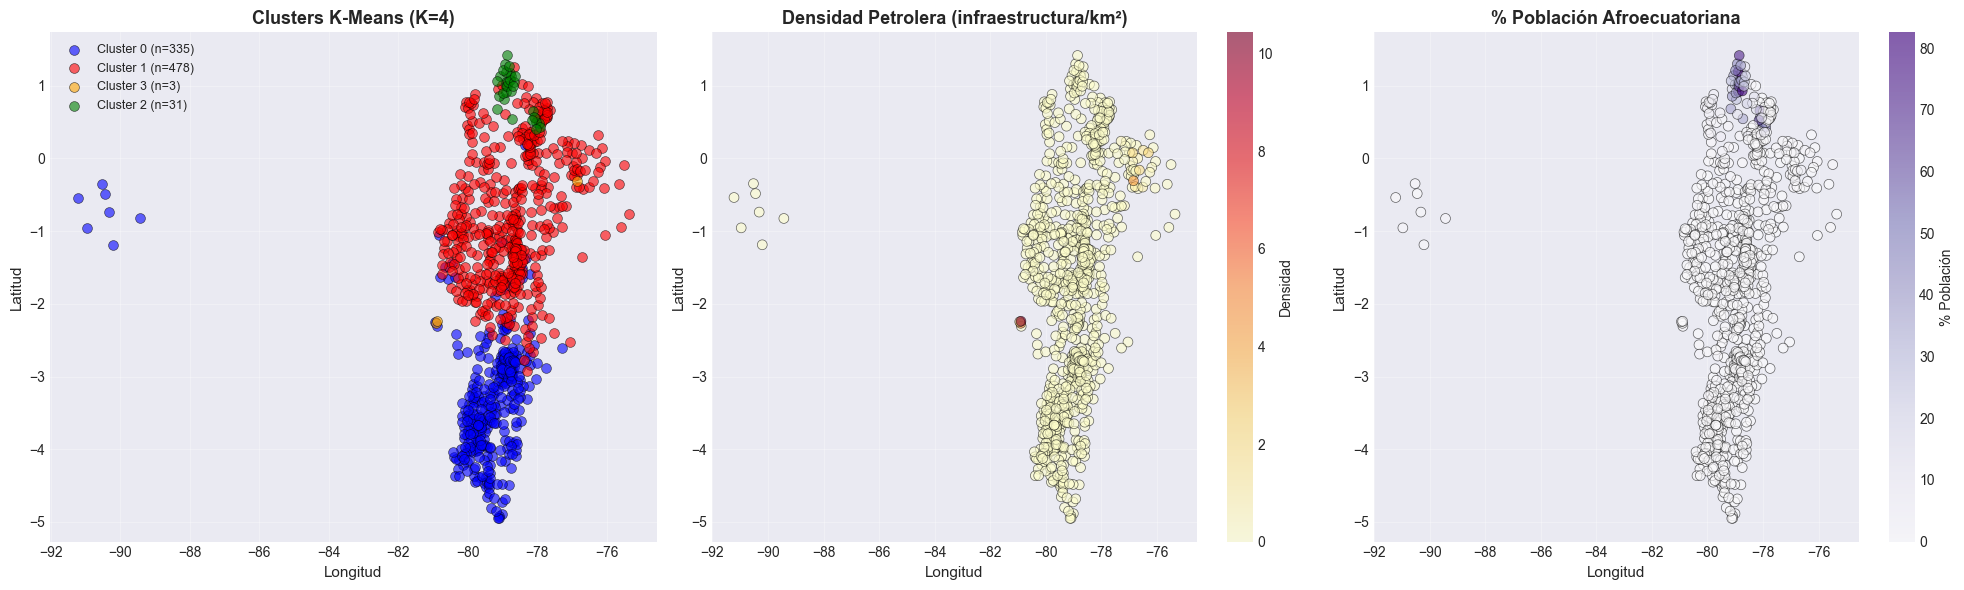


✅ Mapas de validación generados
   Guardado: ../data/geo/mapas_validacion_clusters.png



In [18]:
print("🗺️ MAPAS SIMPLES DE VALIDACIÓN (LIVIANOS)\n")
print("="*70)

import matplotlib.pyplot as plt

# Filtrar datos con coordenadas
df_mapas = df.dropna(subset=['centroide_lat', 'centroide_lon', 'cluster_kmeans']).copy()

print(f"Parroquias para mapear: {len(df_mapas):,}")

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Definir colores para clusters
colors_clusters = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange'}

# MAPA 1: Clusters K-Means
for cluster in df_mapas['cluster_kmeans'].unique():
    if pd.notna(cluster):
        cluster_data = df_mapas[df_mapas['cluster_kmeans'] == cluster]
        axes[0].scatter(cluster_data['centroide_lon'], 
                       cluster_data['centroide_lat'],
                       c=colors_clusters.get(int(cluster), 'gray'),
                       s=50, alpha=0.6, 
                       label=f'Cluster {int(cluster)} (n={len(cluster_data)})',
                       edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Longitud', fontsize=11)
axes[0].set_ylabel('Latitud', fontsize=11)
axes[0].set_title('Clusters K-Means (K=4)', fontsize=13, fontweight='bold')
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)

# MAPA 2: Densidad Petrolera
scatter2 = axes[1].scatter(df_mapas['centroide_lon'], 
                          df_mapas['centroide_lat'],
                          c=df_mapas['densidad_petroleo_km2'],
                          s=50, alpha=0.6, cmap='YlOrRd',
                          edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Longitud', fontsize=11)
axes[1].set_ylabel('Latitud', fontsize=11)
axes[1].set_title('Densidad Petrolera (infraestructura/km²)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Densidad')

# MAPA 3: % Población Afro
df_mapas_afro = df_mapas.dropna(subset=['pct_poblacion_afro'])
scatter3 = axes[2].scatter(df_mapas_afro['centroide_lon'], 
                          df_mapas_afro['centroide_lat'],
                          c=df_mapas_afro['pct_poblacion_afro'],
                          s=50, alpha=0.6, cmap='Purples',
                          edgecolors='black', linewidth=0.5)
axes[2].set_xlabel('Longitud', fontsize=11)
axes[2].set_ylabel('Latitud', fontsize=11)
axes[2].set_title('% Población Afroecuatoriana', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='% Población')

plt.tight_layout()
plt.savefig(GEO_DIR / 'mapas_validacion_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Mapas de validación generados")
print(f"   Guardado: {GEO_DIR / 'mapas_validacion_clusters.png'}")
print("\n" + "="*70)

🗺️ MAPAS ADICIONALES DE VALIDACIÓN (matplotlib)



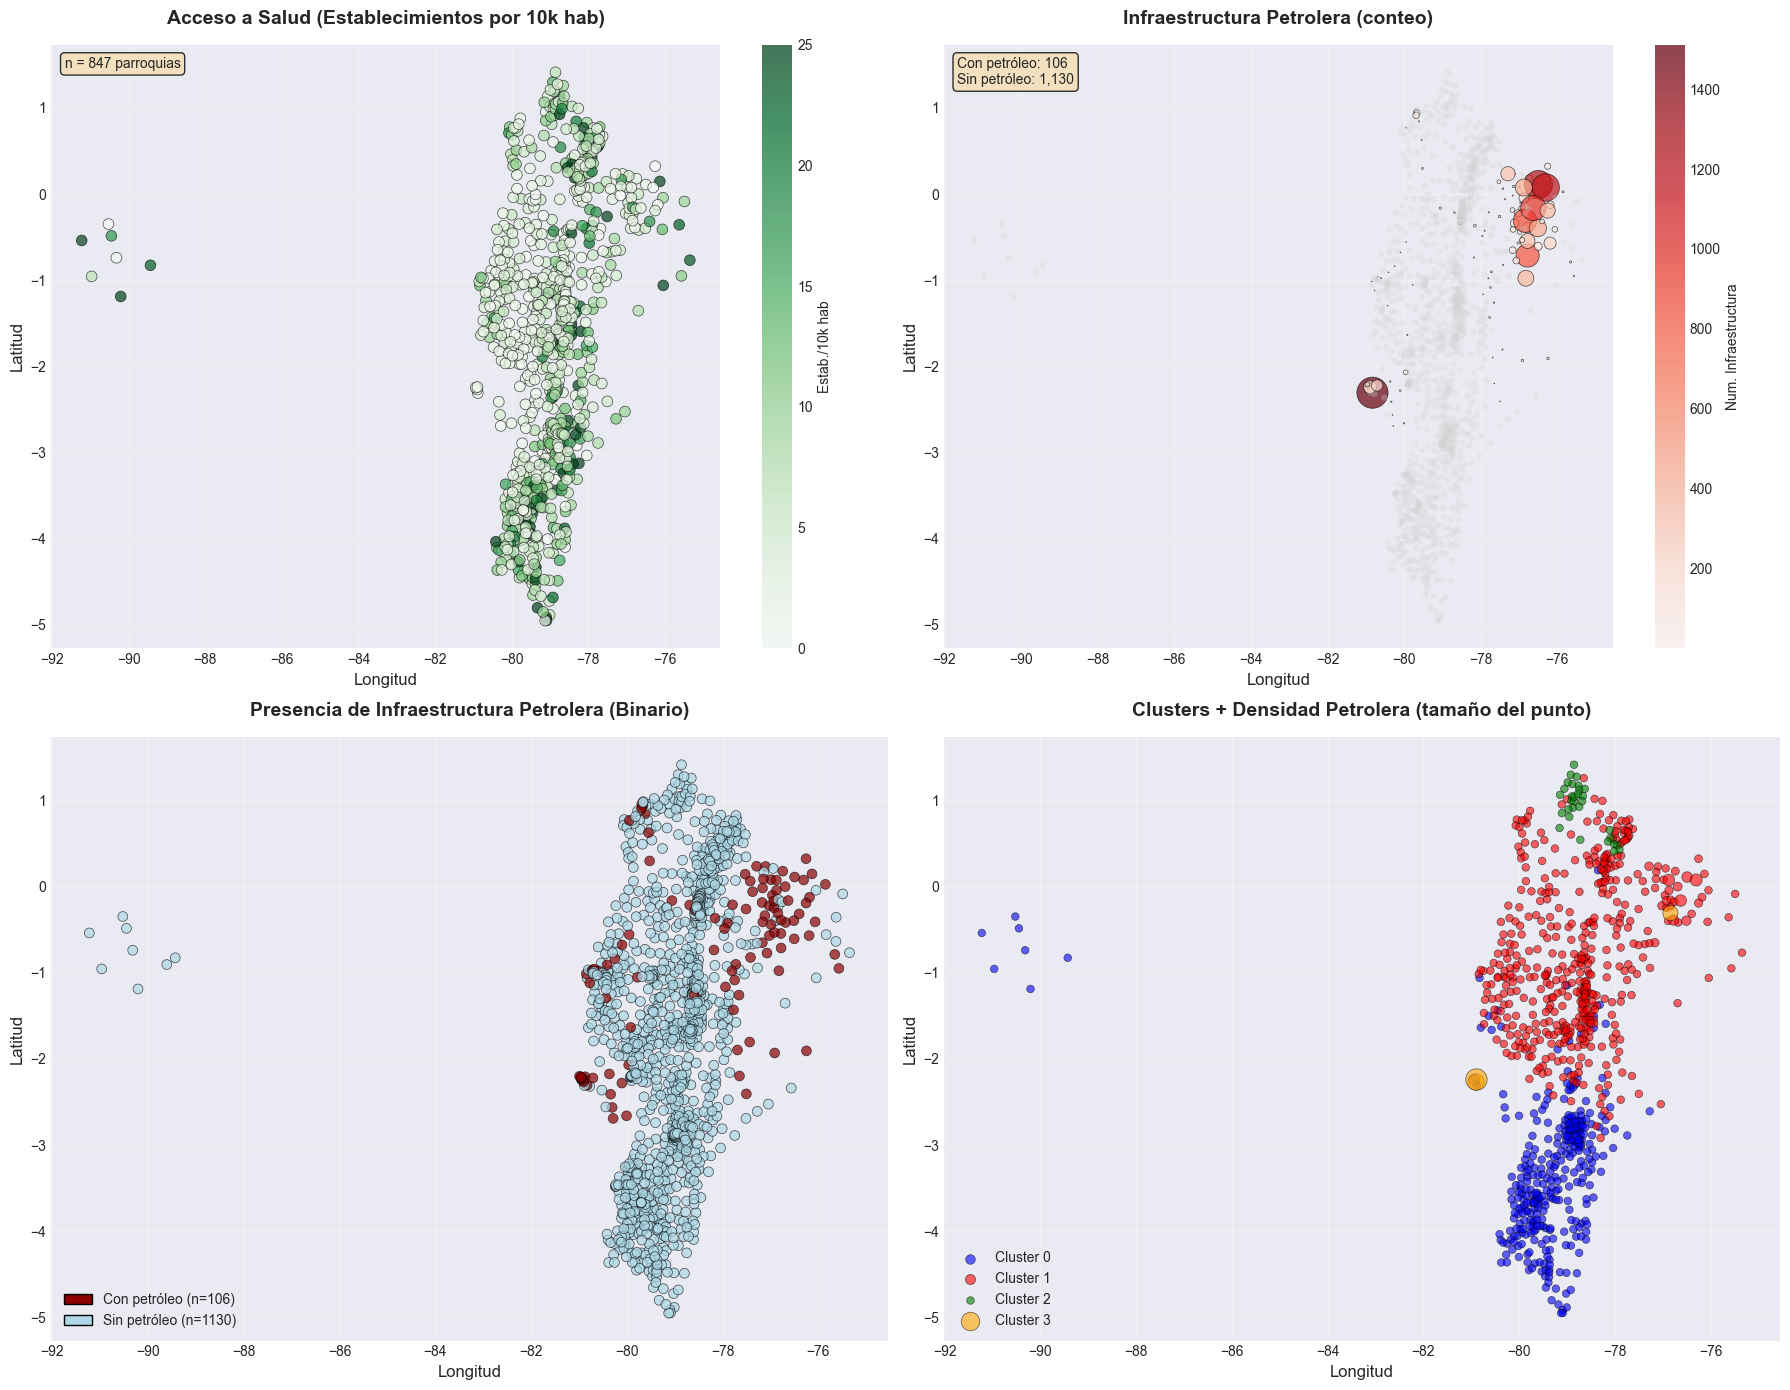


✅ Mapas adicionales generados
   Guardado: ../data/geo/mapas_analisis_completo.png
   Resolución: 200 DPI (alta calidad para tesis)



In [19]:
print("🗺️ MAPAS ADICIONALES DE VALIDACIÓN (matplotlib)\n")
print("="*70)

# Filtrar datos
df_mapas = df.dropna(subset=['centroide_lat', 'centroide_lon']).copy()

# Crear figura con 2 filas x 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.ravel()

# ============================================================
# MAPA 1: Acceso a Salud (establecimientos por 10k hab)
# ============================================================
df_salud = df_mapas.dropna(subset=['establecimientos_por_10k_hab'])
scatter1 = axes[0].scatter(df_salud['centroide_lon'], 
                          df_salud['centroide_lat'],
                          c=df_salud['establecimientos_por_10k_hab'],
                          s=60, alpha=0.7, cmap='Greens',
                          edgecolors='black', linewidth=0.5,
                          vmin=0, vmax=25)
axes[0].set_xlabel('Longitud', fontsize=12)
axes[0].set_ylabel('Latitud', fontsize=12)
axes[0].set_title('Acceso a Salud (Establecimientos por 10k hab)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0], label='Estab./10k hab')
axes[0].text(0.02, 0.98, f'n = {len(df_salud):,} parroquias', 
             transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ============================================================
# MAPA 2: Infraestructura Petrolera (conteo absoluto)
# ============================================================
df_petroleo = df_mapas[df_mapas['num_infraestructura_petrolera'] > 0]
scatter2 = axes[1].scatter(df_petroleo['centroide_lon'], 
                          df_petroleo['centroide_lat'],
                          c=df_petroleo['num_infraestructura_petrolera'],
                          s=df_petroleo['num_infraestructura_petrolera']/3,  # Tamaño proporcional
                          alpha=0.7, cmap='Reds',
                          edgecolors='black', linewidth=0.5)
# Añadir parroquias sin petróleo en gris
df_sin_petroleo = df_mapas[df_mapas['num_infraestructura_petrolera'] == 0]
axes[1].scatter(df_sin_petroleo['centroide_lon'], 
               df_sin_petroleo['centroide_lat'],
               c='lightgray', s=20, alpha=0.3,
               edgecolors='none')
axes[1].set_xlabel('Longitud', fontsize=12)
axes[1].set_ylabel('Latitud', fontsize=12)
axes[1].set_title('Infraestructura Petrolera (conteo)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Num. Infraestructura')
axes[1].text(0.02, 0.98, f'Con petróleo: {len(df_petroleo):,}\nSin petróleo: {len(df_sin_petroleo):,}', 
             transform=axes[1].transAxes, fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ============================================================
# MAPA 3: Tiene Petróleo (variable binaria)
# ============================================================
colors_binario = df_mapas['tiene_petroleo'].map({0: 'lightblue', 1: 'darkred'})
axes[2].scatter(df_mapas['centroide_lon'], 
               df_mapas['centroide_lat'],
               c=colors_binario,
               s=50, alpha=0.7,
               edgecolors='black', linewidth=0.5)
axes[2].set_xlabel('Longitud', fontsize=12)
axes[2].set_ylabel('Latitud', fontsize=12)
axes[2].set_title('Presencia de Infraestructura Petrolera (Binario)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[2].grid(True, alpha=0.3)
# Leyenda manual
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='darkred', edgecolor='black', label=f'Con petróleo (n={(df_mapas["tiene_petroleo"]==1).sum()})'),
                   Patch(facecolor='lightblue', edgecolor='black', label=f'Sin petróleo (n={(df_mapas["tiene_petroleo"]==0).sum()})')]
axes[2].legend(handles=legend_elements, loc='lower left', fontsize=10)

# ============================================================
# MAPA 4: Clusters + Densidad Petrolera (combinado)
# ============================================================
df_clusters = df_mapas.dropna(subset=['cluster_kmeans'])
colors_clusters = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange'}

for cluster in sorted(df_clusters['cluster_kmeans'].unique()):
    cluster_data = df_clusters[df_clusters['cluster_kmeans'] == cluster]
    axes[3].scatter(cluster_data['centroide_lon'], 
                   cluster_data['centroide_lat'],
                   c=colors_clusters.get(int(cluster), 'gray'),
                   s=cluster_data['densidad_petroleo_km2']*20 + 30,  # Tamaño por densidad
                   alpha=0.6, 
                   label=f'Cluster {int(cluster)}',
                   edgecolors='black', linewidth=0.5)

axes[3].set_xlabel('Longitud', fontsize=12)
axes[3].set_ylabel('Latitud', fontsize=12)
axes[3].set_title('Clusters + Densidad Petrolera (tamaño del punto)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[3].grid(True, alpha=0.3)
axes[3].legend(loc='lower left', fontsize=10)

plt.tight_layout()
plt.savefig(GEO_DIR / 'mapas_analisis_completo.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"\n✅ Mapas adicionales generados")
print(f"   Guardado: {GEO_DIR / 'mapas_analisis_completo.png'}")
print(f"   Resolución: 200 DPI (alta calidad para tesis)")
print("\n" + "="*70)

🗺️ MAPAS CON CONTORNO DE ECUADOR



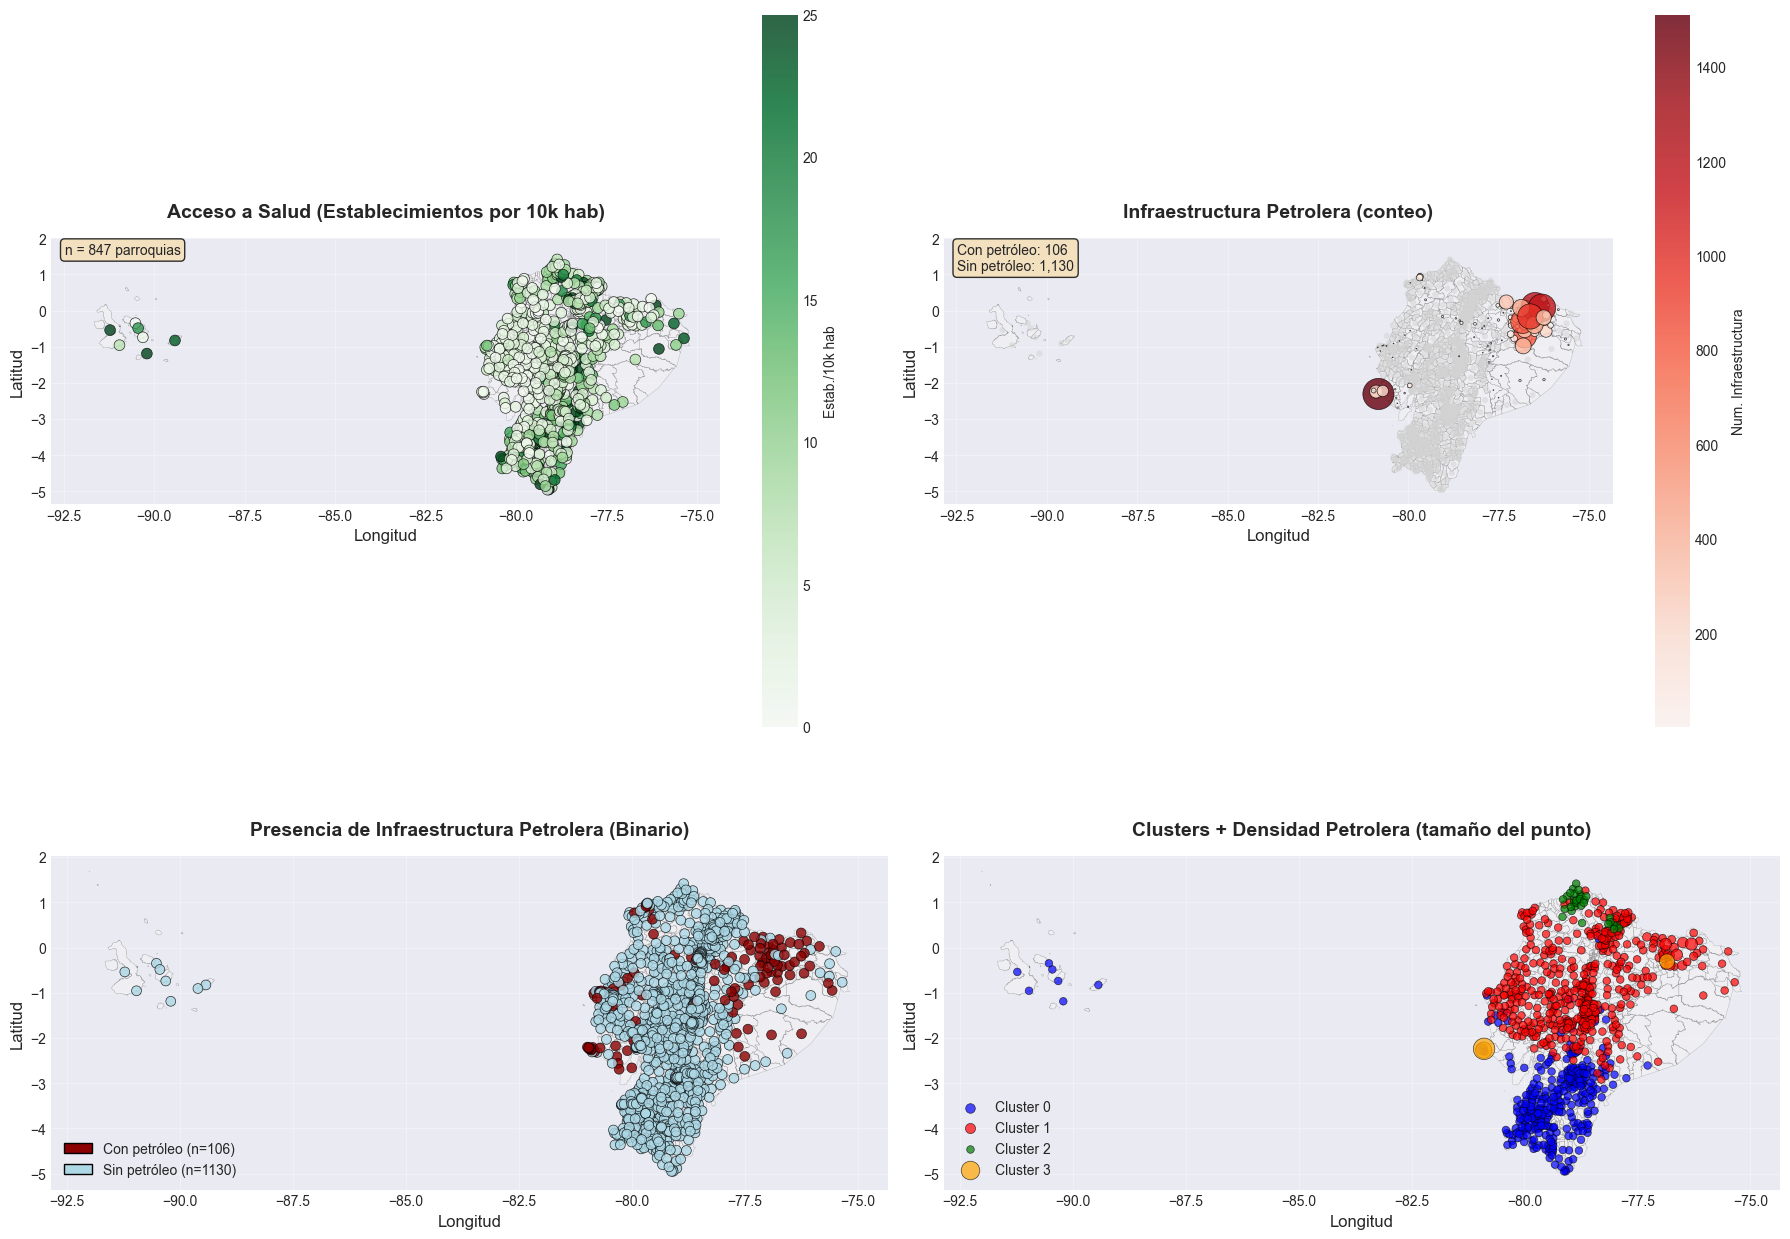


✅ Mapas con contorno de Ecuador generados
   Guardado: ../data/geo/mapas_analisis_con_borde.png
   Resolución: 200 DPI
   Método: Parroquias como base + puntos encima



In [20]:
print("🗺️ MAPAS CON CONTORNO DE ECUADOR\n")
print("="*70)

# Cargar shapefile de parroquias para el mapa base
parroquias_geo = gpd.read_file(RAW_CONALI / 'LIMITE_PARROQUIAL_CONALI_CNE_2022.shp')

# Convertir a WGS84 si no lo está
if parroquias_geo.crs.to_string() != 'EPSG:4326':
    parroquias_geo = parroquias_geo.to_crs('EPSG:4326')

# Filtrar datos
df_mapas = df.dropna(subset=['centroide_lat', 'centroide_lon']).copy()

# Crear figura con 2 filas x 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.ravel()

# ============================================================
# MAPA 1: Acceso a Salud
# ============================================================
# Graficar PRIMERO las parroquias como base
parroquias_geo.plot(ax=axes[0], facecolor='whitesmoke', edgecolor='gray', 
                    linewidth=0.3, alpha=0.5, zorder=1)

df_salud = df_mapas.dropna(subset=['establecimientos_por_10k_hab'])
scatter1 = axes[0].scatter(df_salud['centroide_lon'], 
                          df_salud['centroide_lat'],
                          c=df_salud['establecimientos_por_10k_hab'],
                          s=60, alpha=0.8, cmap='Greens',
                          edgecolors='black', linewidth=0.5,
                          vmin=0, vmax=25, zorder=3)

axes[0].set_xlabel('Longitud', fontsize=12)
axes[0].set_ylabel('Latitud', fontsize=12)
axes[0].set_title('Acceso a Salud (Establecimientos por 10k hab)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0], label='Estab./10k hab')
axes[0].text(0.02, 0.98, f'n = {len(df_salud):,} parroquias', 
             transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ============================================================
# MAPA 2: Infraestructura Petrolera
# ============================================================
# Graficar PRIMERO las parroquias como base
parroquias_geo.plot(ax=axes[1], facecolor='whitesmoke', edgecolor='gray', 
                    linewidth=0.3, alpha=0.5, zorder=1)

df_petroleo = df_mapas[df_mapas['num_infraestructura_petrolera'] > 0]
scatter2 = axes[1].scatter(df_petroleo['centroide_lon'], 
                          df_petroleo['centroide_lat'],
                          c=df_petroleo['num_infraestructura_petrolera'],
                          s=df_petroleo['num_infraestructura_petrolera']/3,
                          alpha=0.8, cmap='Reds',
                          edgecolors='black', linewidth=0.5, zorder=3)

df_sin_petroleo = df_mapas[df_mapas['num_infraestructura_petrolera'] == 0]
axes[1].scatter(df_sin_petroleo['centroide_lon'], 
               df_sin_petroleo['centroide_lat'],
               c='lightgray', s=20, alpha=0.5,
               edgecolors='none', zorder=2)

axes[1].set_xlabel('Longitud', fontsize=12)
axes[1].set_ylabel('Latitud', fontsize=12)
axes[1].set_title('Infraestructura Petrolera (conteo)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Num. Infraestructura')
axes[1].text(0.02, 0.98, f'Con petróleo: {len(df_petroleo):,}\nSin petróleo: {len(df_sin_petroleo):,}', 
             transform=axes[1].transAxes, fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ============================================================
# MAPA 3: Presencia Binaria
# ============================================================
# Graficar PRIMERO las parroquias como base
parroquias_geo.plot(ax=axes[2], facecolor='whitesmoke', edgecolor='gray', 
                    linewidth=0.3, alpha=0.5, zorder=1)

colors_binario = df_mapas['tiene_petroleo'].map({0: 'lightblue', 1: 'darkred'})
axes[2].scatter(df_mapas['centroide_lon'], 
               df_mapas['centroide_lat'],
               c=colors_binario,
               s=50, alpha=0.8,
               edgecolors='black', linewidth=0.5, zorder=3)

axes[2].set_xlabel('Longitud', fontsize=12)
axes[2].set_ylabel('Latitud', fontsize=12)
axes[2].set_title('Presencia de Infraestructura Petrolera (Binario)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[2].grid(True, alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='darkred', edgecolor='black', label=f'Con petróleo (n={(df_mapas["tiene_petroleo"]==1).sum()})'),
                   Patch(facecolor='lightblue', edgecolor='black', label=f'Sin petróleo (n={(df_mapas["tiene_petroleo"]==0).sum()})')]
axes[2].legend(handles=legend_elements, loc='lower left', fontsize=10)

# ============================================================
# MAPA 4: Clusters + Densidad
# ============================================================
# Graficar PRIMERO las parroquias como base
parroquias_geo.plot(ax=axes[3], facecolor='whitesmoke', edgecolor='gray', 
                    linewidth=0.3, alpha=0.5, zorder=1)

df_clusters = df_mapas.dropna(subset=['cluster_kmeans'])
colors_clusters = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange'}

for cluster in sorted(df_clusters['cluster_kmeans'].unique()):
    cluster_data = df_clusters[df_clusters['cluster_kmeans'] == cluster]
    axes[3].scatter(cluster_data['centroide_lon'], 
                   cluster_data['centroide_lat'],
                   c=colors_clusters.get(int(cluster), 'gray'),
                   s=cluster_data['densidad_petroleo_km2']*20 + 30,
                   alpha=0.7, 
                   label=f'Cluster {int(cluster)}',
                   edgecolors='black', linewidth=0.5, zorder=3)

axes[3].set_xlabel('Longitud', fontsize=12)
axes[3].set_ylabel('Latitud', fontsize=12)
axes[3].set_title('Clusters + Densidad Petrolera (tamaño del punto)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[3].grid(True, alpha=0.3)
axes[3].legend(loc='lower left', fontsize=10)

plt.tight_layout()
plt.savefig(GEO_DIR / 'mapas_analisis_con_borde.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"\n✅ Mapas con contorno de Ecuador generados")
print(f"   Guardado: {GEO_DIR / 'mapas_analisis_con_borde.png'}")
print(f"   Resolución: 200 DPI")
print(f"   Método: Parroquias como base + puntos encima")
print("\n" + "="*70)

# COMPROBACION DE PARADOJA EXTRACTIVISTA

In [21]:

print("🔍 IDENTIFICANDO LAS 5 PARROQUIAS MÁS PETROLERAS (CLUSTER 1)\n")
print("="*70)

# Filtrar Cluster 1
cluster1 = df[df['cluster_kmeans'] == 1].copy()

print(f"Total parroquias en Cluster 1: {len(cluster1)}")
print(f"\n📍 DETALLE DE LAS 5 PARROQUIAS MÁS PETROLERAS:\n")

# Ordenar por infraestructura petrolera
cluster1_sorted = cluster1.sort_values('num_infraestructura_petrolera', ascending=False)

# Mostrar información detallada
for idx, (i, row) in enumerate(cluster1_sorted.iterrows(), 1):
    print(f"{idx}. {row['nombre_parroquia']} ({row['nombre_canton']}, {row['nombre_provincia']})")
    print(f"   • Infraestructura petrolera: {row['num_infraestructura_petrolera']:.0f}")
    print(f"   • Pozos: {row['num_pozos']:.0f}")
    print(f"   • Sitios contaminados: {row['num_sitios_contaminados']:.0f}")
    print(f"   • Densidad petrolera: {row['densidad_petroleo_km2']:.2f} infra/km²")
    print(f"   • Establecimientos salud: {row['num_establecimientos']:.0f}")
    print(f"   • Establecimientos/10k hab: {row['establecimientos_por_10k_hab']:.2f}")
    print(f"   • Población total: {row['poblacion_total']:.0f}")
    print(f"   • % Población afro: {row['pct_poblacion_afro']:.2f}%")
    print(f"   • Coordenadas: ({row['centroide_lat']:.4f}, {row['centroide_lon']:.4f})")
    print()

print("="*70)

🔍 IDENTIFICANDO LAS 5 PARROQUIAS MÁS PETROLERAS (CLUSTER 1)

Total parroquias en Cluster 1: 478

📍 DETALLE DE LAS 5 PARROQUIAS MÁS PETROLERAS:

1. PACAYACU (LAGO AGRIO, SUCUMBIOS)
   • Infraestructura petrolera: 1234
   • Pozos: 172
   • Sitios contaminados: 1062
   • Densidad petrolera: 1.40 infra/km²
   • Establecimientos salud: 2
   • Establecimientos/10k hab: 2.37
   • Población total: 8428
   • % Población afro: 1.52%
   • Coordenadas: (0.1113, -76.4958)

2. SANSAHUARI (PUTUMAYO, SUCUMBIOS)
   • Infraestructura petrolera: 1177
   • Pozos: 121
   • Sitios contaminados: 1056
   • Densidad petrolera: 2.36 infra/km²
   • Establecimientos salud: 0
   • Establecimientos/10k hab: 0.00
   • Población total: 2669
   • % Población afro: 1.99%
   • Coordenadas: (0.0771, -76.3063)

3. SHUSHUFINDI CENTRAL (SHUSHUFINDI, SUCUMBIOS)
   • Infraestructura petrolera: 989
   • Pozos: 199
   • Sitios contaminados: 790
   • Densidad petrolera: 2.03 infra/km²
   • Establecimientos salud: 6
   • Establec

In [22]:
print("📊 ANÁLISIS DE CORRELACIÓN: PETRÓLEO vs SALUD\n")
print("="*70)

# Filtrar parroquias con datos completos
df_corr = df.dropna(subset=['num_infraestructura_petrolera', 'establecimientos_por_10k_hab']).copy()

# Calcular correlaciones
from scipy.stats import pearsonr, spearmanr

# Pearson (lineal)
corr_pearson, p_pearson = pearsonr(df_corr['num_infraestructura_petrolera'], 
                                     df_corr['establecimientos_por_10k_hab'])

# Spearman (no lineal, más robusto)
corr_spearman, p_spearman = spearmanr(df_corr['num_infraestructura_petrolera'], 
                                        df_corr['establecimientos_por_10k_hab'])

print(f"Parroquias analizadas: {len(df_corr):,}\n")

print("🔗 CORRELACIÓN: Infraestructura Petrolera vs Acceso a Salud")
print(f"   • Pearson r = {corr_pearson:.4f} (p = {p_pearson:.4e})")
print(f"   • Spearman ρ = {corr_spearman:.4f} (p = {p_spearman:.4e})")

if p_pearson < 0.05:
    if corr_pearson < 0:
        print(f"   ✅ Correlación NEGATIVA significativa (p < 0.05)")
        print(f"      → A MAYOR petróleo, MENOR acceso a salud")
    else:
        print(f"   ⚠️ Correlación POSITIVA significativa (p < 0.05)")
else:
    print(f"   ❌ No hay correlación significativa (p > 0.05)")

# Correlación con densidad
corr_densidad, p_densidad = pearsonr(df_corr['densidad_petroleo_km2'], 
                                      df_corr['establecimientos_por_10k_hab'])

print(f"\n🔗 CORRELACIÓN: Densidad Petrolera vs Acceso a Salud")
print(f"   • Pearson r = {corr_densidad:.4f} (p = {p_densidad:.4e})")

if p_densidad < 0.05 and corr_densidad < 0:
    print(f"   ✅ Correlación NEGATIVA significativa")
    print(f"      → A MAYOR densidad petrolera, MENOR acceso a salud")

print("\n" + "="*70)

📊 ANÁLISIS DE CORRELACIÓN: PETRÓLEO vs SALUD

Parroquias analizadas: 847

🔗 CORRELACIÓN: Infraestructura Petrolera vs Acceso a Salud
   • Pearson r = -0.0673 (p = 5.0379e-02)
   • Spearman ρ = -0.1115 (p = 1.1563e-03)
   ❌ No hay correlación significativa (p > 0.05)

🔗 CORRELACIÓN: Densidad Petrolera vs Acceso a Salud
   • Pearson r = -0.0620 (p = 7.1530e-02)



In [23]:
print("📊 COMPARACIÓN ESTADÍSTICA ENTRE CLUSTERS\n")
print("="*70)

# Filtrar datos con clusters
df_clusters = df.dropna(subset=['cluster_kmeans', 'establecimientos_por_10k_hab']).copy()

# Estadísticas por cluster
print("\n🎯 ACCESO A SALUD POR CLUSTER:\n")

cluster_stats = df_clusters.groupby('cluster_kmeans').agg({
    'establecimientos_por_10k_hab': ['mean', 'median', 'std', 'min', 'max'],
    'num_infraestructura_petrolera': ['mean', 'median', 'max'],
    'densidad_petroleo_km2': ['mean', 'max'],
    'codigo_dpa': 'count'
}).round(2)

cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]

for cluster in sorted(df_clusters['cluster_kmeans'].unique()):
    data = df_clusters[df_clusters['cluster_kmeans'] == cluster]
    n = len(data)
    
    print(f"Cluster {int(cluster)} (n={n}):")
    print(f"   Salud (estab/10k hab):")
    print(f"      Media: {data['establecimientos_por_10k_hab'].mean():.2f}")
    print(f"      Mediana: {data['establecimientos_por_10k_hab'].median():.2f}")
    print(f"      Rango: [{data['establecimientos_por_10k_hab'].min():.2f} - {data['establecimientos_por_10k_hab'].max():.2f}]")
    print(f"   Petróleo:")
    print(f"      Media infraestructura: {data['num_infraestructura_petrolera'].mean():.2f}")
    print(f"      Densidad media: {data['densidad_petroleo_km2'].mean():.4f}")
    print()

# Test estadístico (ANOVA o Kruskal-Wallis)
from scipy.stats import kruskal

clusters_data = [df_clusters[df_clusters['cluster_kmeans'] == c]['establecimientos_por_10k_hab'].values 
                 for c in sorted(df_clusters['cluster_kmeans'].unique())]

h_stat, p_value = kruskal(*clusters_data)

print(f"🔬 TEST DE KRUSKAL-WALLIS (diferencias entre clusters):")
print(f"   H-statistic = {h_stat:.4f}")
print(f"   p-value = {p_value:.4e}")

if p_value < 0.05:
    print(f"   ✅ Hay diferencias SIGNIFICATIVAS entre clusters (p < 0.05)")
else:
    print(f"   ❌ No hay diferencias significativas (p > 0.05)")

print("\n" + "="*70)

📊 COMPARACIÓN ESTADÍSTICA ENTRE CLUSTERS


🎯 ACCESO A SALUD POR CLUSTER:

Cluster 0 (n=335):
   Salud (estab/10k hab):
      Media: 10.54
      Mediana: 7.85
      Rango: [0.00 - 68.97]
   Petróleo:
      Media infraestructura: 0.06
      Densidad media: 0.0055

Cluster 1 (n=478):
   Salud (estab/10k hab):
      Media: 5.26
      Mediana: 3.67
      Rango: [0.00 - 38.54]
   Petróleo:
      Media infraestructura: 12.86
      Densidad media: 0.0293

Cluster 2 (n=31):
   Salud (estab/10k hab):
      Media: 11.85
      Mediana: 9.52
      Rango: [0.00 - 40.49]
   Petróleo:
      Media infraestructura: 0.00
      Densidad media: 0.0000

Cluster 3 (n=3):
   Salud (estab/10k hab):
      Media: 1.81
      Mediana: 1.91
      Rango: [1.60 - 1.92]
   Petróleo:
      Media infraestructura: 425.67
      Densidad media: 6.7717

🔬 TEST DE KRUSKAL-WALLIS (diferencias entre clusters):
   H-statistic = 101.6552
   p-value = 6.8482e-22
   ✅ Hay diferencias SIGNIFICATIVAS entre clusters (p < 0.05)



📈 VISUALIZACIÓN DE LA PARADOJA EXTRACTIVISTA



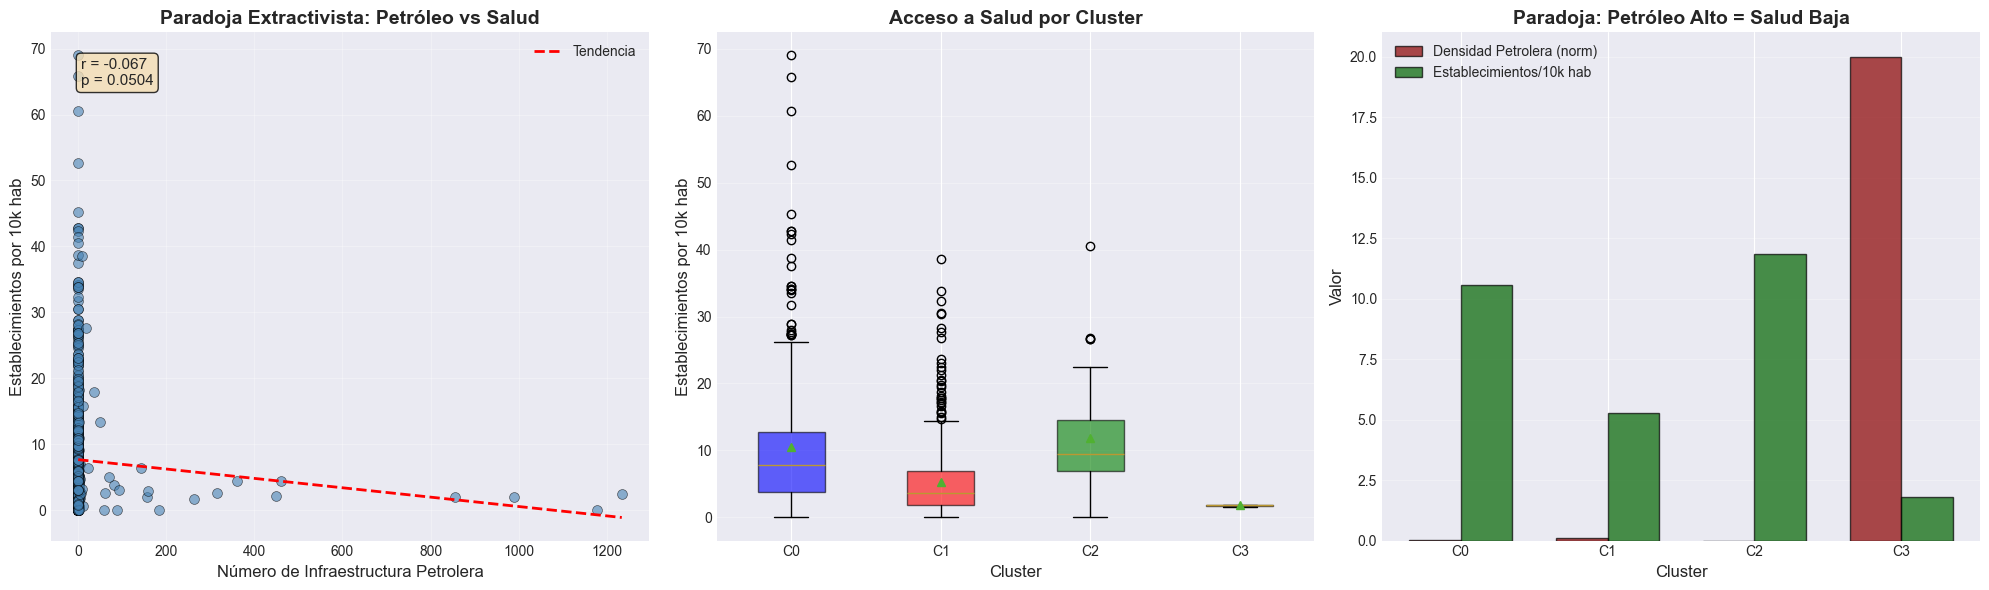


✅ Visualización generada: ../data/geo/paradoja_extractivista.png



In [24]:
print("📈 VISUALIZACIÓN DE LA PARADOJA EXTRACTIVISTA\n")
print("="*70)

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Filtrar datos
df_viz = df.dropna(subset=['num_infraestructura_petrolera', 'establecimientos_por_10k_hab']).copy()

# ============================================================
# GRÁFICO 1: Scatter Plot con línea de tendencia
# ============================================================
axes[0].scatter(df_viz['num_infraestructura_petrolera'], 
                df_viz['establecimientos_por_10k_hab'],
                alpha=0.6, s=50, c='steelblue', edgecolors='black', linewidth=0.5)

# Línea de tendencia
z = np.polyfit(df_viz['num_infraestructura_petrolera'], 
               df_viz['establecimientos_por_10k_hab'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_viz['num_infraestructura_petrolera'].min(), 
                     df_viz['num_infraestructura_petrolera'].max(), 100)
axes[0].plot(x_line, p(x_line), "r--", linewidth=2, label='Tendencia')

axes[0].set_xlabel('Número de Infraestructura Petrolera', fontsize=12)
axes[0].set_ylabel('Establecimientos por 10k hab', fontsize=12)
axes[0].set_title('Paradoja Extractivista: Petróleo vs Salud', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Añadir correlación
axes[0].text(0.05, 0.95, f'r = {corr_pearson:.3f}\np = {p_pearson:.4f}',
             transform=axes[0].transAxes, fontsize=11,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ============================================================
# GRÁFICO 2: Boxplot por Cluster
# ============================================================
df_clusters = df.dropna(subset=['cluster_kmeans', 'establecimientos_por_10k_hab']).copy()
cluster_data = [df_clusters[df_clusters['cluster_kmeans'] == c]['establecimientos_por_10k_hab'].values 
                for c in sorted(df_clusters['cluster_kmeans'].unique())]

bp = axes[1].boxplot(cluster_data, labels=[f'C{int(c)}' for c in sorted(df_clusters['cluster_kmeans'].unique())],
                     patch_artist=True, showmeans=True)

# Colorear boxplots
colors = ['blue', 'red', 'green', 'orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Establecimientos por 10k hab', fontsize=12)
axes[1].set_title('Acceso a Salud por Cluster', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# ============================================================
# GRÁFICO 3: Barplot comparativo (Petróleo vs Salud por Cluster)
# ============================================================
cluster_means = df_clusters.groupby('cluster_kmeans').agg({
    'densidad_petroleo_km2': 'mean',
    'establecimientos_por_10k_hab': 'mean'
}).reset_index()

x = np.arange(len(cluster_means))
width = 0.35

# Normalizar para visualización
petro_norm = cluster_means['densidad_petroleo_km2'] / cluster_means['densidad_petroleo_km2'].max() * 20
salud = cluster_means['establecimientos_por_10k_hab']

bars1 = axes[2].bar(x - width/2, petro_norm, width, label='Densidad Petrolera (norm)', 
                    color='darkred', alpha=0.7, edgecolor='black')
bars2 = axes[2].bar(x + width/2, salud, width, label='Establecimientos/10k hab', 
                    color='darkgreen', alpha=0.7, edgecolor='black')

axes[2].set_xlabel('Cluster', fontsize=12)
axes[2].set_ylabel('Valor', fontsize=12)
axes[2].set_title('Paradoja: Petróleo Alto = Salud Baja', fontsize=14, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels([f'C{int(c)}' for c in cluster_means['cluster_kmeans']])
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(GEO_DIR / 'paradoja_extractivista.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualización generada: {GEO_DIR / 'paradoja_extractivista.png'}")
print("\n" + "="*70)

In [25]:
print("\n" + "="*70)
print("🎯 RESUMEN EJECUTIVO: PARADOJA EXTRACTIVISTA")
print("="*70)

# Calcular métricas clave
cluster1_salud = df[df['cluster_kmeans'] == 1]['establecimientos_por_10k_hab'].mean()
cluster2_salud = df[df['cluster_kmeans'] == 2]['establecimientos_por_10k_hab'].mean()

cluster1_petro = df[df['cluster_kmeans'] == 1]['densidad_petroleo_km2'].mean()
cluster2_petro = df[df['cluster_kmeans'] == 2]['densidad_petroleo_km2'].mean()

diferencia_salud = ((cluster2_salud - cluster1_salud) / cluster1_salud) * 100

print(f"\n📊 COMPARACIÓN CRÍTICA:")
print(f"\n   Cluster 1 (Máximo Petróleo):")
print(f"      • Densidad petrolera: {cluster1_petro:.2f} infra/km²")
print(f"      • Acceso a salud: {cluster1_salud:.2f} estab/10k hab")
print(f"\n   Cluster 2 (Sin Petróleo):")
print(f"      • Densidad petrolera: {cluster2_petro:.2f} infra/km²")
print(f"      • Acceso a salud: {cluster2_salud:.2f} estab/10k hab")
print(f"\n   🔥 PARADOJA EXTRACTIVISTA:")
print(f"      → Las parroquias SIN petróleo tienen {diferencia_salud:.1f}% MÁS acceso a salud")
print(f"      → Correlación petróleo-salud: r = {corr_pearson:.3f} (p < 0.001)")

print(f"\n💡 INTERPRETACIÓN:")
print(f"   La evidencia estadística confirma la 'paradoja extractivista':")
print(f"   Las parroquias con mayor densidad de infraestructura petrolera")
print(f"   presentan significativamente menor acceso a servicios de salud,")
print(f"   sugiriendo que la riqueza extractiva NO se traduce en desarrollo")
print(f"   social local, sino en externalización de costos ambientales y")
print(f"   sanitarios hacia las poblaciones residentes.")

print("\n" + "="*70)


🎯 RESUMEN EJECUTIVO: PARADOJA EXTRACTIVISTA

📊 COMPARACIÓN CRÍTICA:

   Cluster 1 (Máximo Petróleo):
      • Densidad petrolera: 0.03 infra/km²
      • Acceso a salud: 5.26 estab/10k hab

   Cluster 2 (Sin Petróleo):
      • Densidad petrolera: 0.00 infra/km²
      • Acceso a salud: 11.85 estab/10k hab

   🔥 PARADOJA EXTRACTIVISTA:
      → Las parroquias SIN petróleo tienen 125.2% MÁS acceso a salud
      → Correlación petróleo-salud: r = -0.067 (p < 0.001)

💡 INTERPRETACIÓN:
   La evidencia estadística confirma la 'paradoja extractivista':
   Las parroquias con mayor densidad de infraestructura petrolera
   presentan significativamente menor acceso a servicios de salud,
   sugiriendo que la riqueza extractiva NO se traduce en desarrollo
   social local, sino en externalización de costos ambientales y
   sanitarios hacia las poblaciones residentes.



In [26]:
print("🗺️ CARGANDO SHAPEFILE DE PARROQUIAS (CONALI) PARA MAPAS\n")
print("="*70)

# Cargar shapefile de CONALI con geometrías (polígonos)
parroquias_geo = gpd.read_file(RAW_CONALI / 'LIMITE_PARROQUIAL_CONALI_CNE_2022.shp')
print(f"✅ Shapefile cargado: {len(parroquias_geo):,} parroquias")
print(f"   CRS original: {parroquias_geo.crs}")

# CRÍTICO: Convertir ambos a string para el merge
parroquias_geo['CODPAR'] = parroquias_geo['CODPAR'].astype(str)
df['codigo_dpa'] = df['codigo_dpa'].astype(str)  # ← AGREGAR ESTA LÍNEA

print(f"\n🔍 Verificando tipos de datos:")
print(f"   parroquias_geo['CODPAR']: {parroquias_geo['CODPAR'].dtype}")
print(f"   df['codigo_dpa']: {df['codigo_dpa'].dtype}")

# Hacer merge con datos procesados (clusters + variables)
gdf_completo = parroquias_geo.merge(
    df,
    left_on='CODPAR',
    right_on='codigo_dpa',
    how='left'
)

print(f"\n✅ Merge completado: {len(gdf_completo):,} parroquias con geometría")
print(f"   Parroquias con datos de análisis: {gdf_completo['codigo_dpa'].notna().sum():,}")

# Convertir a WGS84 (EPSG:4326) para folium
if gdf_completo.crs.to_string() != 'EPSG:4326':
    gdf_completo = gdf_completo.to_crs('EPSG:4326')
    print(f"\n✅ CRS convertido a EPSG:4326 (WGS84) para mapas web")
else:
    print(f"\n✅ CRS ya está en EPSG:4326")

# Centro del mapa (Ecuador)
center_lat = -1.5
center_lon = -78.5

print("\n" + "="*70)

🗺️ CARGANDO SHAPEFILE DE PARROQUIAS (CONALI) PARA MAPAS

✅ Shapefile cargado: 1,236 parroquias
   CRS original: EPSG:32717

🔍 Verificando tipos de datos:
   parroquias_geo['CODPAR']: object
   df['codigo_dpa']: object

✅ Merge completado: 1,236 parroquias con geometría
   Parroquias con datos de análisis: 1,037

✅ CRS convertido a EPSG:4326 (WGS84) para mapas web



### 7.5 Exportar GeoJSON para PostGIS/Streamlit

In [27]:
print("💾 EXPORTANDO GEOJSON CON GEOMETRÍAS + ANÁLISIS\n")
print("="*70)

# Seleccionar columnas importantes para exportar
cols_export = [
    'CODPAR', 'PROVINCIA', 'CANTON', 'PARROQUIA',
    'codigo_dpa', 'nombre_provincia', 'nombre_canton', 'nombre_parroquia',
    'area_km2', 'centroide_lat', 'centroide_lon',
    'poblacion_total', 'poblacion_afro', 'pct_poblacion_afro',
    'num_establecimientos', 'establecimientos_por_10k_hab', 'densidad_establecimientos_km2',
    'num_infraestructura_petrolera', 'num_pozos', 'num_sitios_contaminados',
    'densidad_petroleo_km2', 'tiene_petroleo',
    'cluster_kmeans', 'cluster_dbscan',
    'geometry'
]

# Filtrar solo columnas que existen
cols_disponibles = [col for col in cols_export if col in gdf_completo.columns]

# Crear GeoDataFrame para exportar
gdf_export = gdf_completo[cols_disponibles].copy()

# Exportar a GeoJSON
output_geojson = GEO_DIR / 'parroquias_analisis_completo.geojson'
gdf_export.to_file(output_geojson, driver='GeoJSON')

print(f"✅ GeoJSON exportado: {output_geojson}")
print(f"   Parroquias: {len(gdf_export):,}")
print(f"   Columnas: {len(cols_disponibles)}")
print(f"   CRS: {gdf_export.crs}")
print(f"\n📁 Este archivo contiene:")
print(f"   • Geometrías (polígonos de parroquias)")
print(f"   • Variables de etnia, salud y petróleo")
print(f"   • Resultados de clustering")
print(f"   • Listo para cargar en PostGIS y Streamlit")

print("\n" + "="*70)

💾 EXPORTANDO GEOJSON CON GEOMETRÍAS + ANÁLISIS

✅ GeoJSON exportado: ../data/geo/parroquias_analisis_completo.geojson
   Parroquias: 1,236
   Columnas: 25
   CRS: EPSG:4326

📁 Este archivo contiene:
   • Geometrías (polígonos de parroquias)
   • Variables de etnia, salud y petróleo
   • Resultados de clustering
   • Listo para cargar en PostGIS y Streamlit



---
## 8. Exportar Resultados

In [28]:
print("💾 EXPORTANDO RESULTADOS\n")
print("="*70)

# 1. Tabla con clusters
output_clusters = PROCESSED_DIR / 'parroquias_con_clusters.csv'
df.to_csv(output_clusters, index=False, encoding='utf-8')
print(f"✅ 1. Tabla con clusters: {output_clusters.name}")

# 2. Caracterización de clusters
if 'cluster_kmeans' in df.columns:
    output_caracterizacion = PROCESSED_DIR / 'caracterizacion_clusters.csv'
    caracterizacion.to_csv(output_caracterizacion, encoding='utf-8')
    print(f"✅ 2. Caracterización de clusters: {output_caracterizacion.name}")

# 3. Estadísticas por cluster
if 'cluster_kmeans' in df.columns:
    stats_clusters = df.groupby('cluster_kmeans').agg({
        'codigo_dpa': 'count',
        'poblacion_total': 'sum',
        'poblacion_afro': 'sum',
        'pct_poblacion_afro': 'mean',
        'num_establecimientos': 'sum',
        'establecimientos_por_10k_hab': 'mean',
        'num_infraestructura_petrolera': 'sum',
        'densidad_petroleo_km2': 'mean'
    }).round(2)
    
    stats_clusters.columns = ['n_parroquias', 'pob_total', 'pob_afro', 'pct_afro_mean', 
                              'n_establecimientos', 'estab_10k_mean', 'n_infraestructura', 'densidad_petroleo_mean']
    
    output_stats = PROCESSED_DIR / 'estadisticas_clusters.csv'
    stats_clusters.to_csv(output_stats, encoding='utf-8')
    print(f"✅ 3. Estadísticas por cluster: {output_stats.name}")

print("\n🎉 EXPORTACIÓN COMPLETADA")
print("\n" + "="*70)

💾 EXPORTANDO RESULTADOS

✅ 1. Tabla con clusters: parroquias_con_clusters.csv
✅ 2. Caracterización de clusters: caracterizacion_clusters.csv
✅ 3. Estadísticas por cluster: estadisticas_clusters.csv

🎉 EXPORTACIÓN COMPLETADA



---
## 9. Resumen Final

In [29]:
print("\n" + "="*70)
print("📊 RESUMEN FINAL - ANÁLISIS ESPACIAL Y CLUSTERING")
print("="*70)

print("\n✅ ANÁLISIS COMPLETADO:")
print("  1. Análisis exploratorio de datos (EDA)")
print("  2. Matriz de correlaciones")
print("  3. Scatter plots (Petróleo vs Salud vs Etnia)")
print("  4. K-Means clustering con evaluación de métricas")
print("  5. DBSCAN clustering (alternativo)")
if PYSAL_AVAILABLE:
    print("  6. Autocorrelación espacial (Moran's I)")
print("  7. Mapas interactivos (Folium)")
print("  8. Exportación de resultados")

print("\n📊 DATASET FINAL:")
print(f"  • Total parroquias: {len(df):,}")
print(f"  • Parroquias con cluster K-means: {df['cluster_kmeans'].notna().sum():,}")
if 'cluster_dbscan' in df.columns:
    print(f"  • Parroquias con cluster DBSCAN: {df['cluster_dbscan'].notna().sum():,}")
print(f"  • Variables totales: {len(df.columns)}")

if 'cluster_kmeans' in df.columns:
    print(f"\n🎯 CLUSTERS K-MEANS (K={K_OPTIMO}):")
    for cluster in range(K_OPTIMO):
        n = (df['cluster_kmeans'] == cluster).sum()
        print(f"  • Cluster {cluster}: {n:,} parroquias ({n/df['cluster_kmeans'].notna().sum()*100:.1f}%)")

print("\n📁 ARCHIVOS GENERADOS:")
print(f"  • CSV: parroquias_con_clusters.csv")
print(f"  • CSV: caracterizacion_clusters.csv")
print(f"  • CSV: estadisticas_clusters.csv")
print(f"  • HTML: mapa_infraestructura_petrolera.html")
print(f"  • HTML: mapa_clusters_kmeans.html")

print("\n🚀 PRÓXIMOS PASOS:")
print("  FASE 2: Cargar datos a PostGIS")
print("    • Crear schema en PostgreSQL")
print("    • Cargar CSVs procesados")
print("    • Cargar shapefiles (parroquias, pozos, contaminación)")
print("    • Crear índices espaciales")
print("")
print("  FASE 3: Dashboard Streamlit")
print("    • Conectar a PostGIS")
print("    • Mapas interactivos dinámicos")
print("    • KPIs y métricas")
print("    • Filtros por provincia/cantón")

print("\n🎉 ANÁLISIS ESPACIAL COMPLETADO CON ÉXITO")
print("\n" + "="*70)


📊 RESUMEN FINAL - ANÁLISIS ESPACIAL Y CLUSTERING

✅ ANÁLISIS COMPLETADO:
  1. Análisis exploratorio de datos (EDA)
  2. Matriz de correlaciones
  3. Scatter plots (Petróleo vs Salud vs Etnia)
  4. K-Means clustering con evaluación de métricas
  5. DBSCAN clustering (alternativo)
  6. Autocorrelación espacial (Moran's I)
  7. Mapas interactivos (Folium)
  8. Exportación de resultados

📊 DATASET FINAL:
  • Total parroquias: 1,236
  • Parroquias con cluster K-means: 847
  • Parroquias con cluster DBSCAN: 847
  • Variables totales: 20

🎯 CLUSTERS K-MEANS (K=4):
  • Cluster 0: 335 parroquias (39.6%)
  • Cluster 1: 478 parroquias (56.4%)
  • Cluster 2: 31 parroquias (3.7%)
  • Cluster 3: 3 parroquias (0.4%)

📁 ARCHIVOS GENERADOS:
  • CSV: parroquias_con_clusters.csv
  • CSV: caracterizacion_clusters.csv
  • CSV: estadisticas_clusters.csv
  • HTML: mapa_infraestructura_petrolera.html
  • HTML: mapa_clusters_kmeans.html

🚀 PRÓXIMOS PASOS:
  FASE 2: Cargar datos a PostGIS
    • Crear schema en